## Epistasis investigation


Investigating how well different measures of gene dispensibilty using flux balance analysis models can predict genetic interactions.


$\epsilon = w_{AB} - w_A \times w_B$



In [1]:
import os
import sys
from warnings import filterwarnings
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import pandas as pd
sys.path.append('../flux_balance_analysis')
from fba_utils import load_sd_minus_his
from single_knockouts import single_knockout_loss_costs, single_knockout_modified_loss_cost


plt.style.use('../flux_balance_analysis/paper.mplstyle')
modelPath = '../data/external/yeast_7.6/yeast_7.6.xml'
modelName = modelPath.split('/')[-1][:-4]
modelDir = '../models/' + modelName
filterwarnings('ignore', 'charge of s_[0-9][0-9][0-9][0-9] is not a number ()')
filterwarnings('ignore', 'uppercase AND/OR found in rule ')
model = load_sd_minus_his(modelPath)
orfs = set([g.id for g in model.genes])
booneData = pd.read_csv('../data/processed/genetic_interactions_filtered.csv',
                            header=0)
booneData = booneData[booneData['Query ORF'].isin(orfs) &
                          booneData['Array ORF'].isin(orfs)]

In [2]:
def gene_pair_id(geneA, geneB):
    return '_'.join(sorted([geneA, geneB]))


dblGeneKOgrowth = {}
with open(os.path.join(modelDir, 'double_gene_loss_growth.csv'), 'r') as f:
    for line in f.readlines():
        geneA, geneB, growth = line.split(',')
        dblGeneKOgrowth[gene_pair_id(geneA, geneB)] = float(growth.strip())
dblFunctionKOgrowth = {}
with open(os.path.join(modelDir, 'double_function_loss_growth.csv'), 'r') as f:
    for line in f.readlines():
        geneA, geneB, growth = line.split(',')
        dblFunctionKOgrowth[gene_pair_id(geneA, geneB)] = float(growth.strip())

In [3]:
# get function loss costs and gene loss costs for this media
didWtGrow, geneLossCosts, functionLossCosts = single_knockout_loss_costs(model)
functionLossCosts = single_knockout_modified_loss_cost(model)
if not didWtGrow:
    raise UserWarning('Wildtype should grow on this media!')

909
695
108


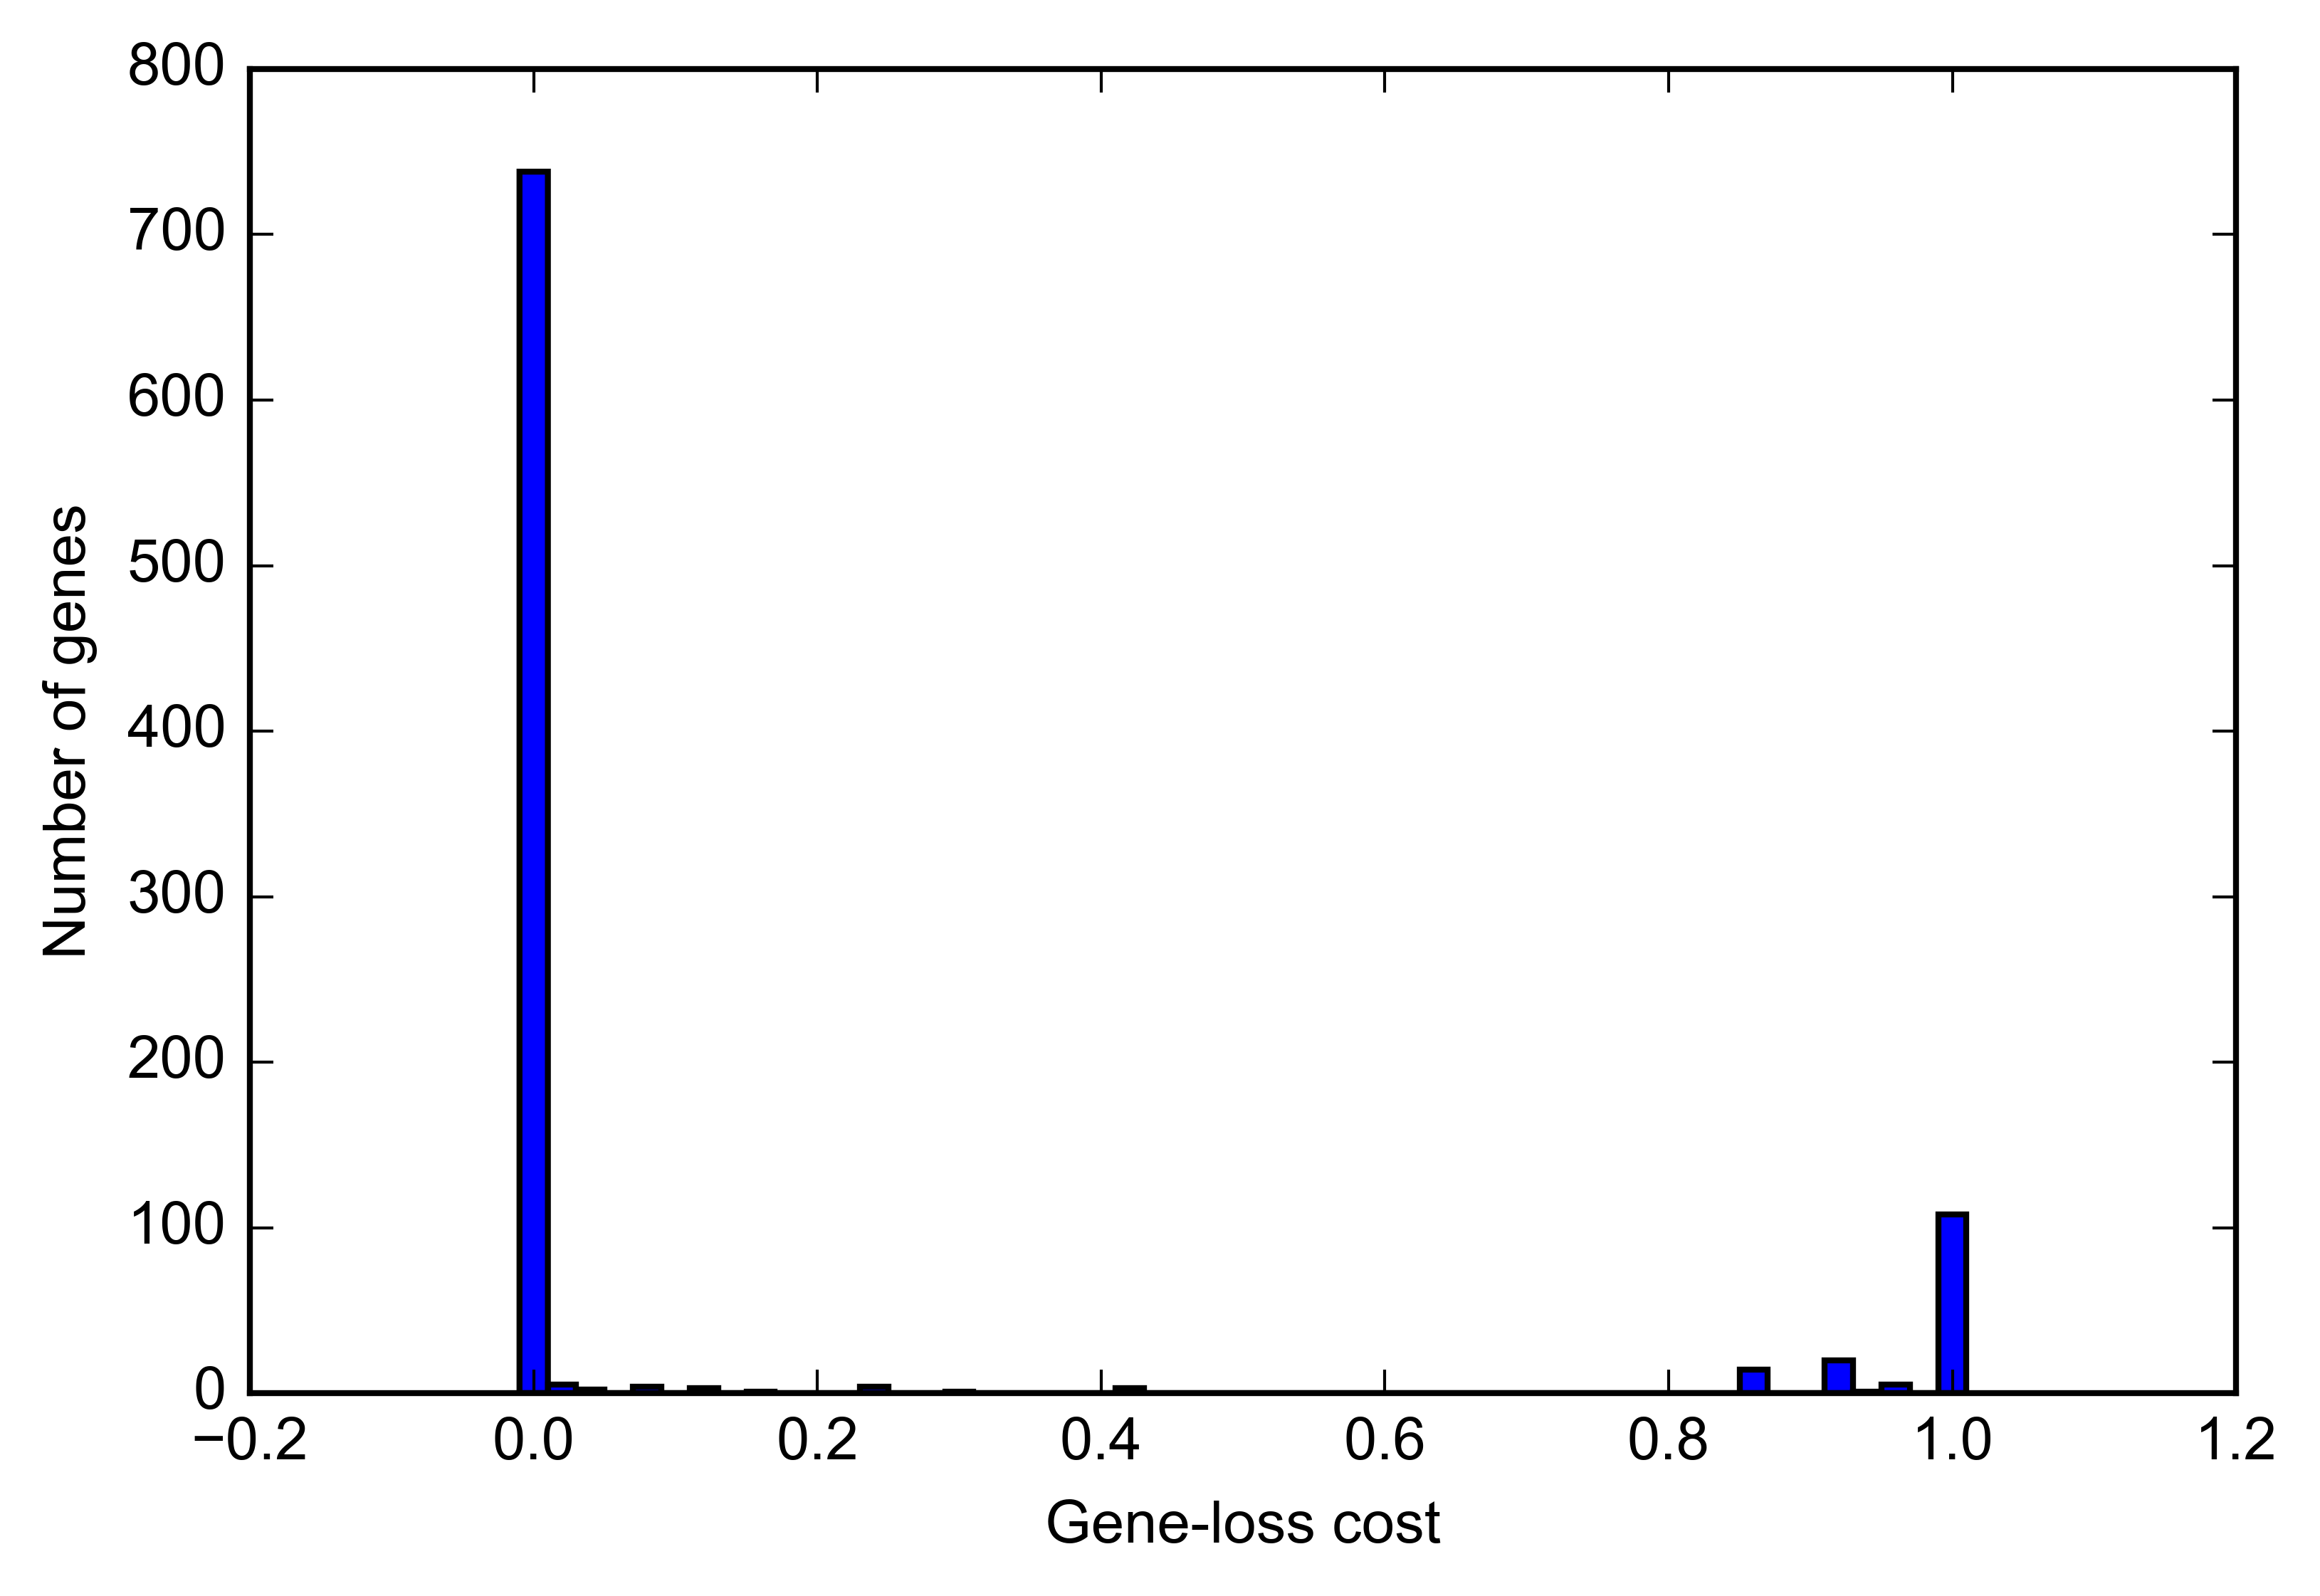

In [4]:
glc = np.array(geneLossCosts.values())
print glc.shape[0]
print sum(glc < 0.00001)
print sum(glc > 0.99)
plt.hist(glc, bins=51, range=(-0.01, 1.01))
plt.xlabel('Gene-loss cost')
plt.ylabel('Number of genes')
plt.show()

909
551
165


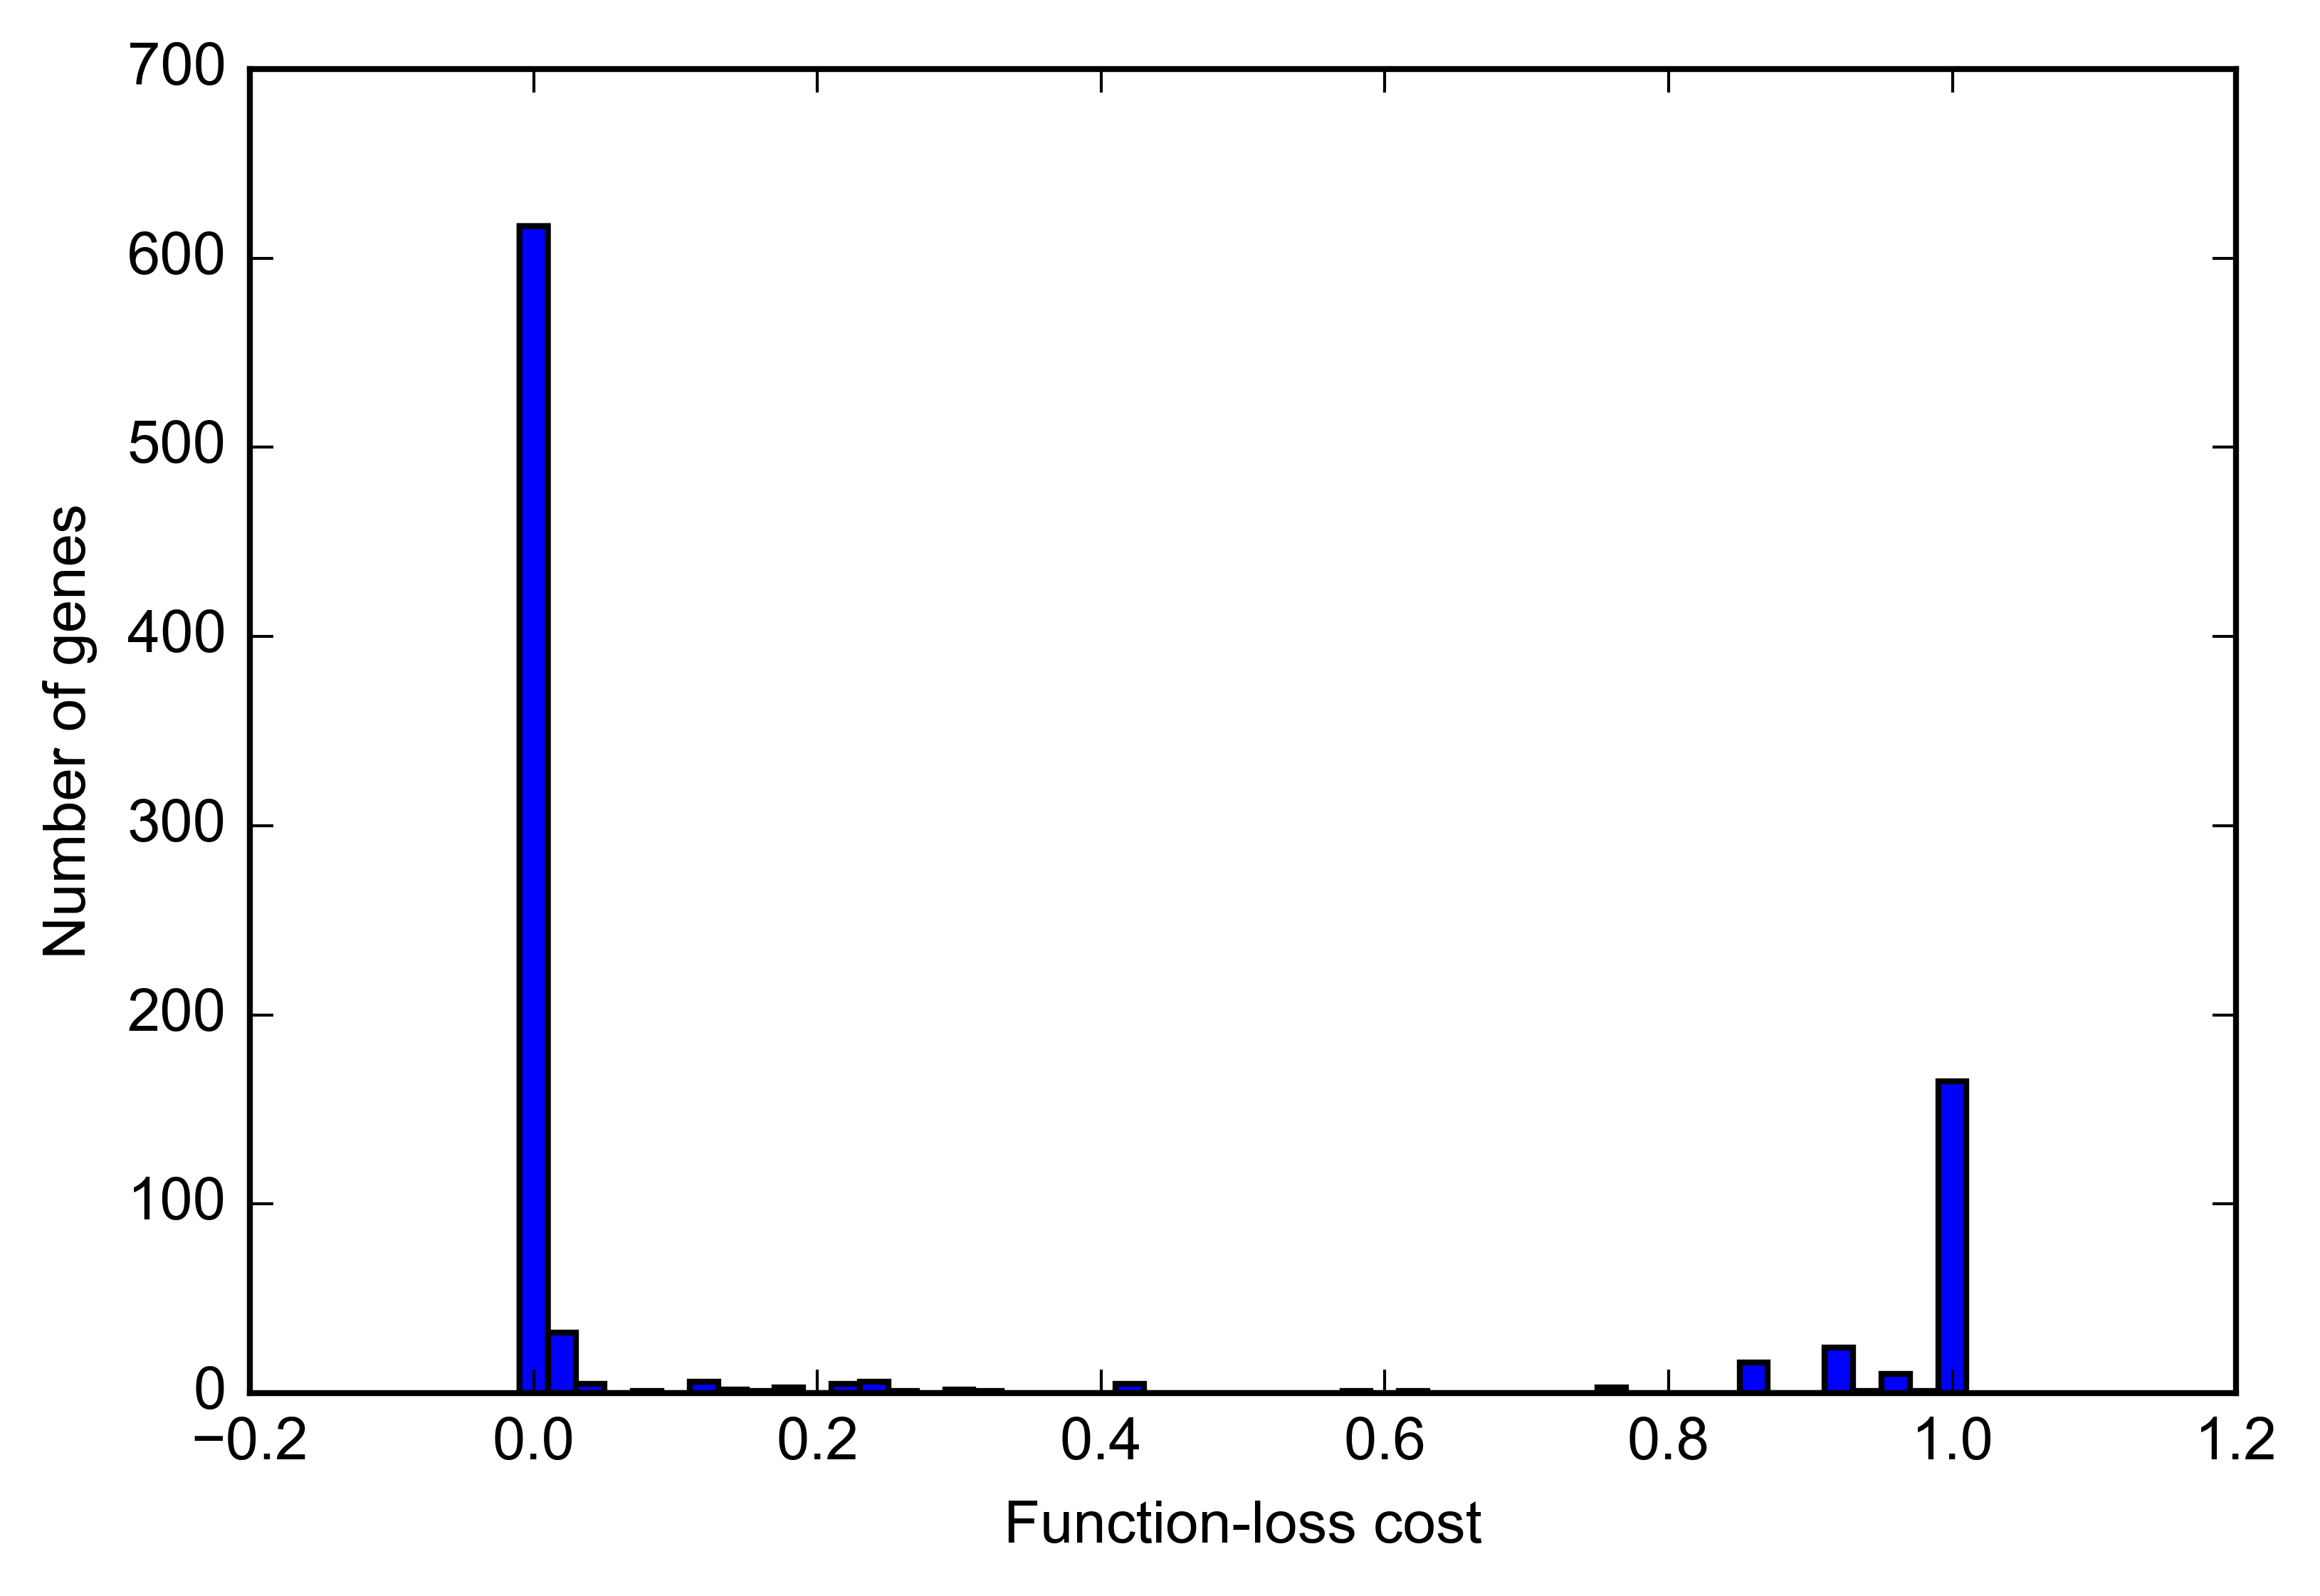

In [5]:
flc = np.array(functionLossCosts.values())
print flc.shape[0]
print sum(flc < 0.00001)
print sum(flc > 0.99)
plt.hist(flc, bins=51, range=(-0.01, 1.01))
plt.xlabel('Function-loss cost')
plt.ylabel('Number of genes')
plt.show()

In [6]:
wtGrowth = model.optimize(solver='gurobi').f

In [7]:
if len(dblGeneKOgrowth) != (len(orfs)**2 - len(orfs)) / 2:
    raise UserWarning('Double gene knockouts unexpected size.')
if len(dblFunctionKOgrowth) != (len(orfs)**2 - len(orfs)) / 2:
    raise UserWarning('Double gene knockouts unexpected size.')

In [8]:
booneData['pair'] = booneData.apply(lambda row: '_'.join(sorted([row['Query ORF'], row['Array ORF']])),
                                    axis=1)
pairToInteraction = {row['pair']: row['interaction'] for _i, row in booneData.iterrows()}
results = pd.DataFrame(columns=['pair'], data=booneData['pair'].unique())
results['geneA'] = results['pair'].apply(lambda x: x.split('_')[0])
results['geneB'] = results['pair'].apply(lambda x: x.split('_')[1])
results['experiment'] = results['pair'].map(lambda x: pairToInteraction.get(x, 'none'))

def epsilon_glc(row):
    return (1. - (wtGrowth - dblGeneKOgrowth[row['pair']]) / wtGrowth) \
                 - ((1. - geneLossCosts[row['geneA']]) * (1. - geneLossCosts[row['geneB']]))
    
    
def epsilon_flc(row):
    return (1. - (wtGrowth - dblFunctionKOgrowth[row['pair']]) / wtGrowth) \
            - ((1. - min(1., functionLossCosts[row['geneA']])) * (1. - min(1., functionLossCosts[row['geneB']])))


results['epsilon_glc'] = results.apply(epsilon_glc, axis=1)
results['epsilon_flc'] = results.apply(epsilon_flc, axis=1)

In [9]:
# remove blocked reactions
print results.shape[0], 'pairs before removing blocked reactions'
with open('../models/yeast_7.6/blocked_genes.txt', 'r') as f:
    blockedGeneNames = set([l.strip() for l in f.readlines()])
results = results[~results['geneA'].isin(blockedGeneNames) & ~results['geneB'].isin(blockedGeneNames)]
print results.shape[0], 'pairs after removing blocked reactions'

29528 pairs before removing blocked reactions
23211 pairs after removing blocked reactions


412686
151505
137029


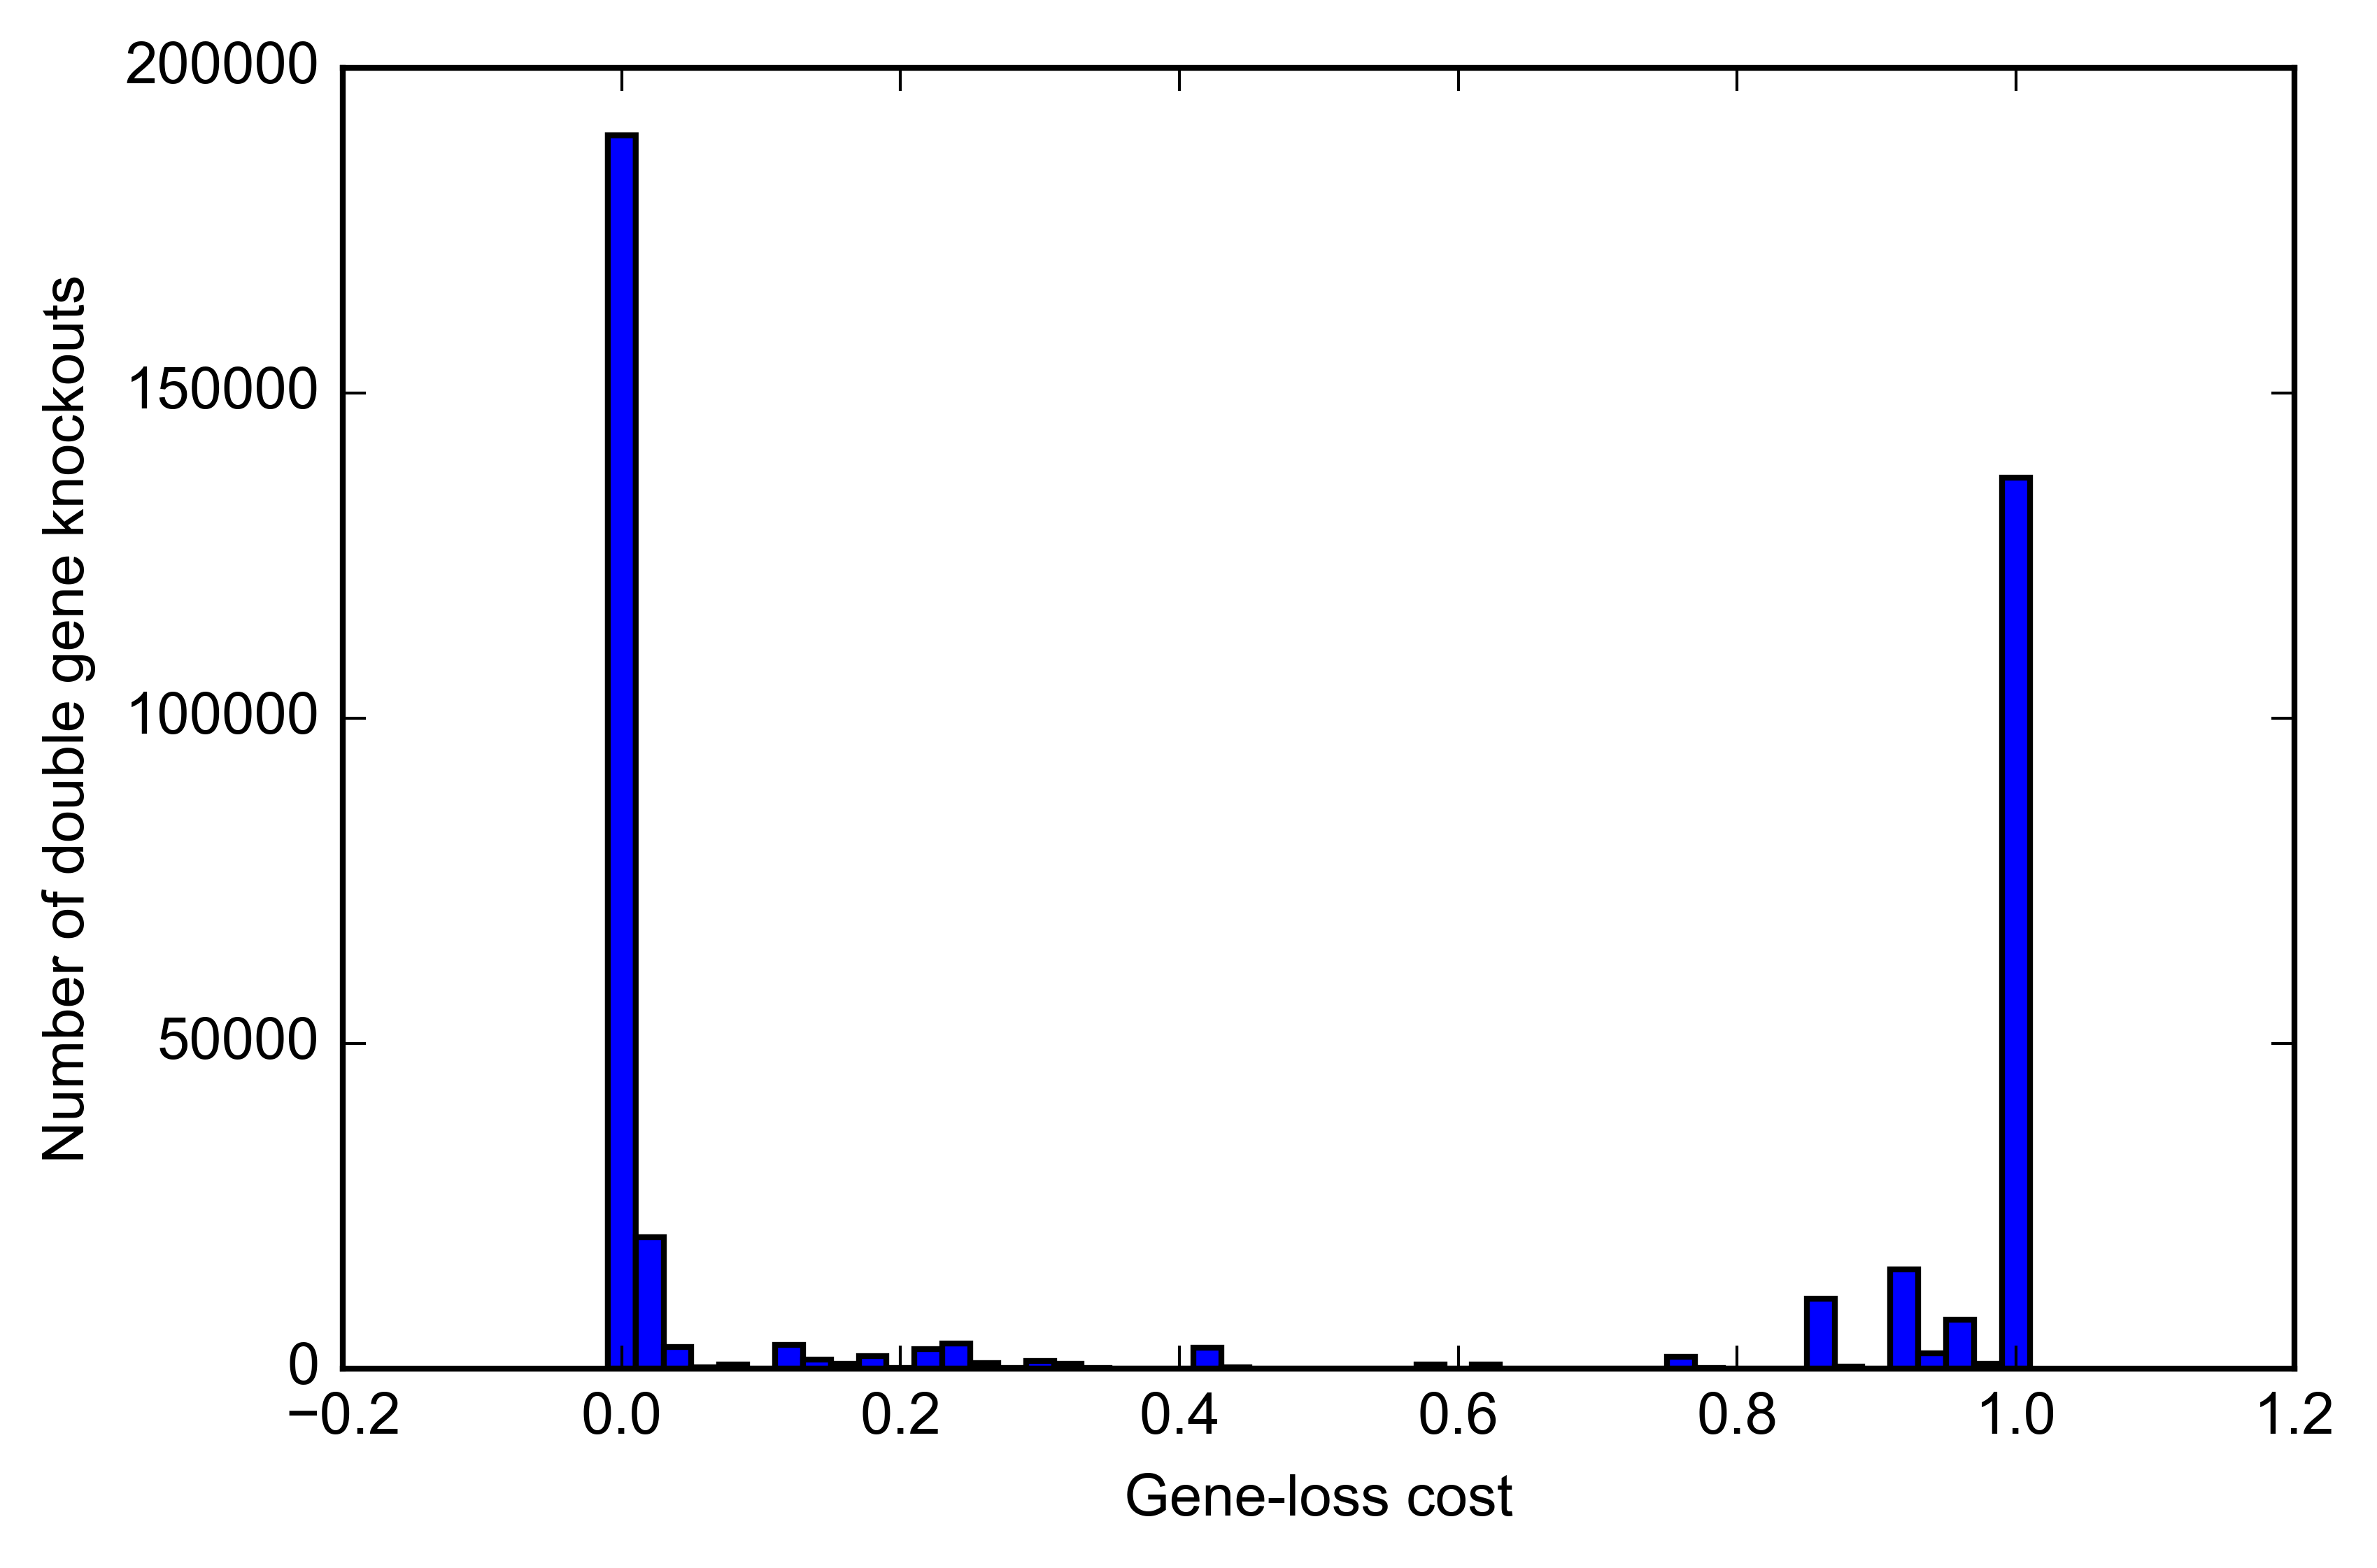

In [10]:
dblGLC = np.array([(wtGrowth - koGrowth) / wtGrowth for koGrowth in dblFunctionKOgrowth.values()])
print dblGLC.shape[0]
print sum(dblGLC < 0.00001)
print sum(dblGLC > 0.99)
plt.hist(dblGLC, bins=51, range=(-0.01, 1.01))
plt.xlabel('Gene-loss cost')
plt.ylabel('Number of double gene knockouts')
plt.show()

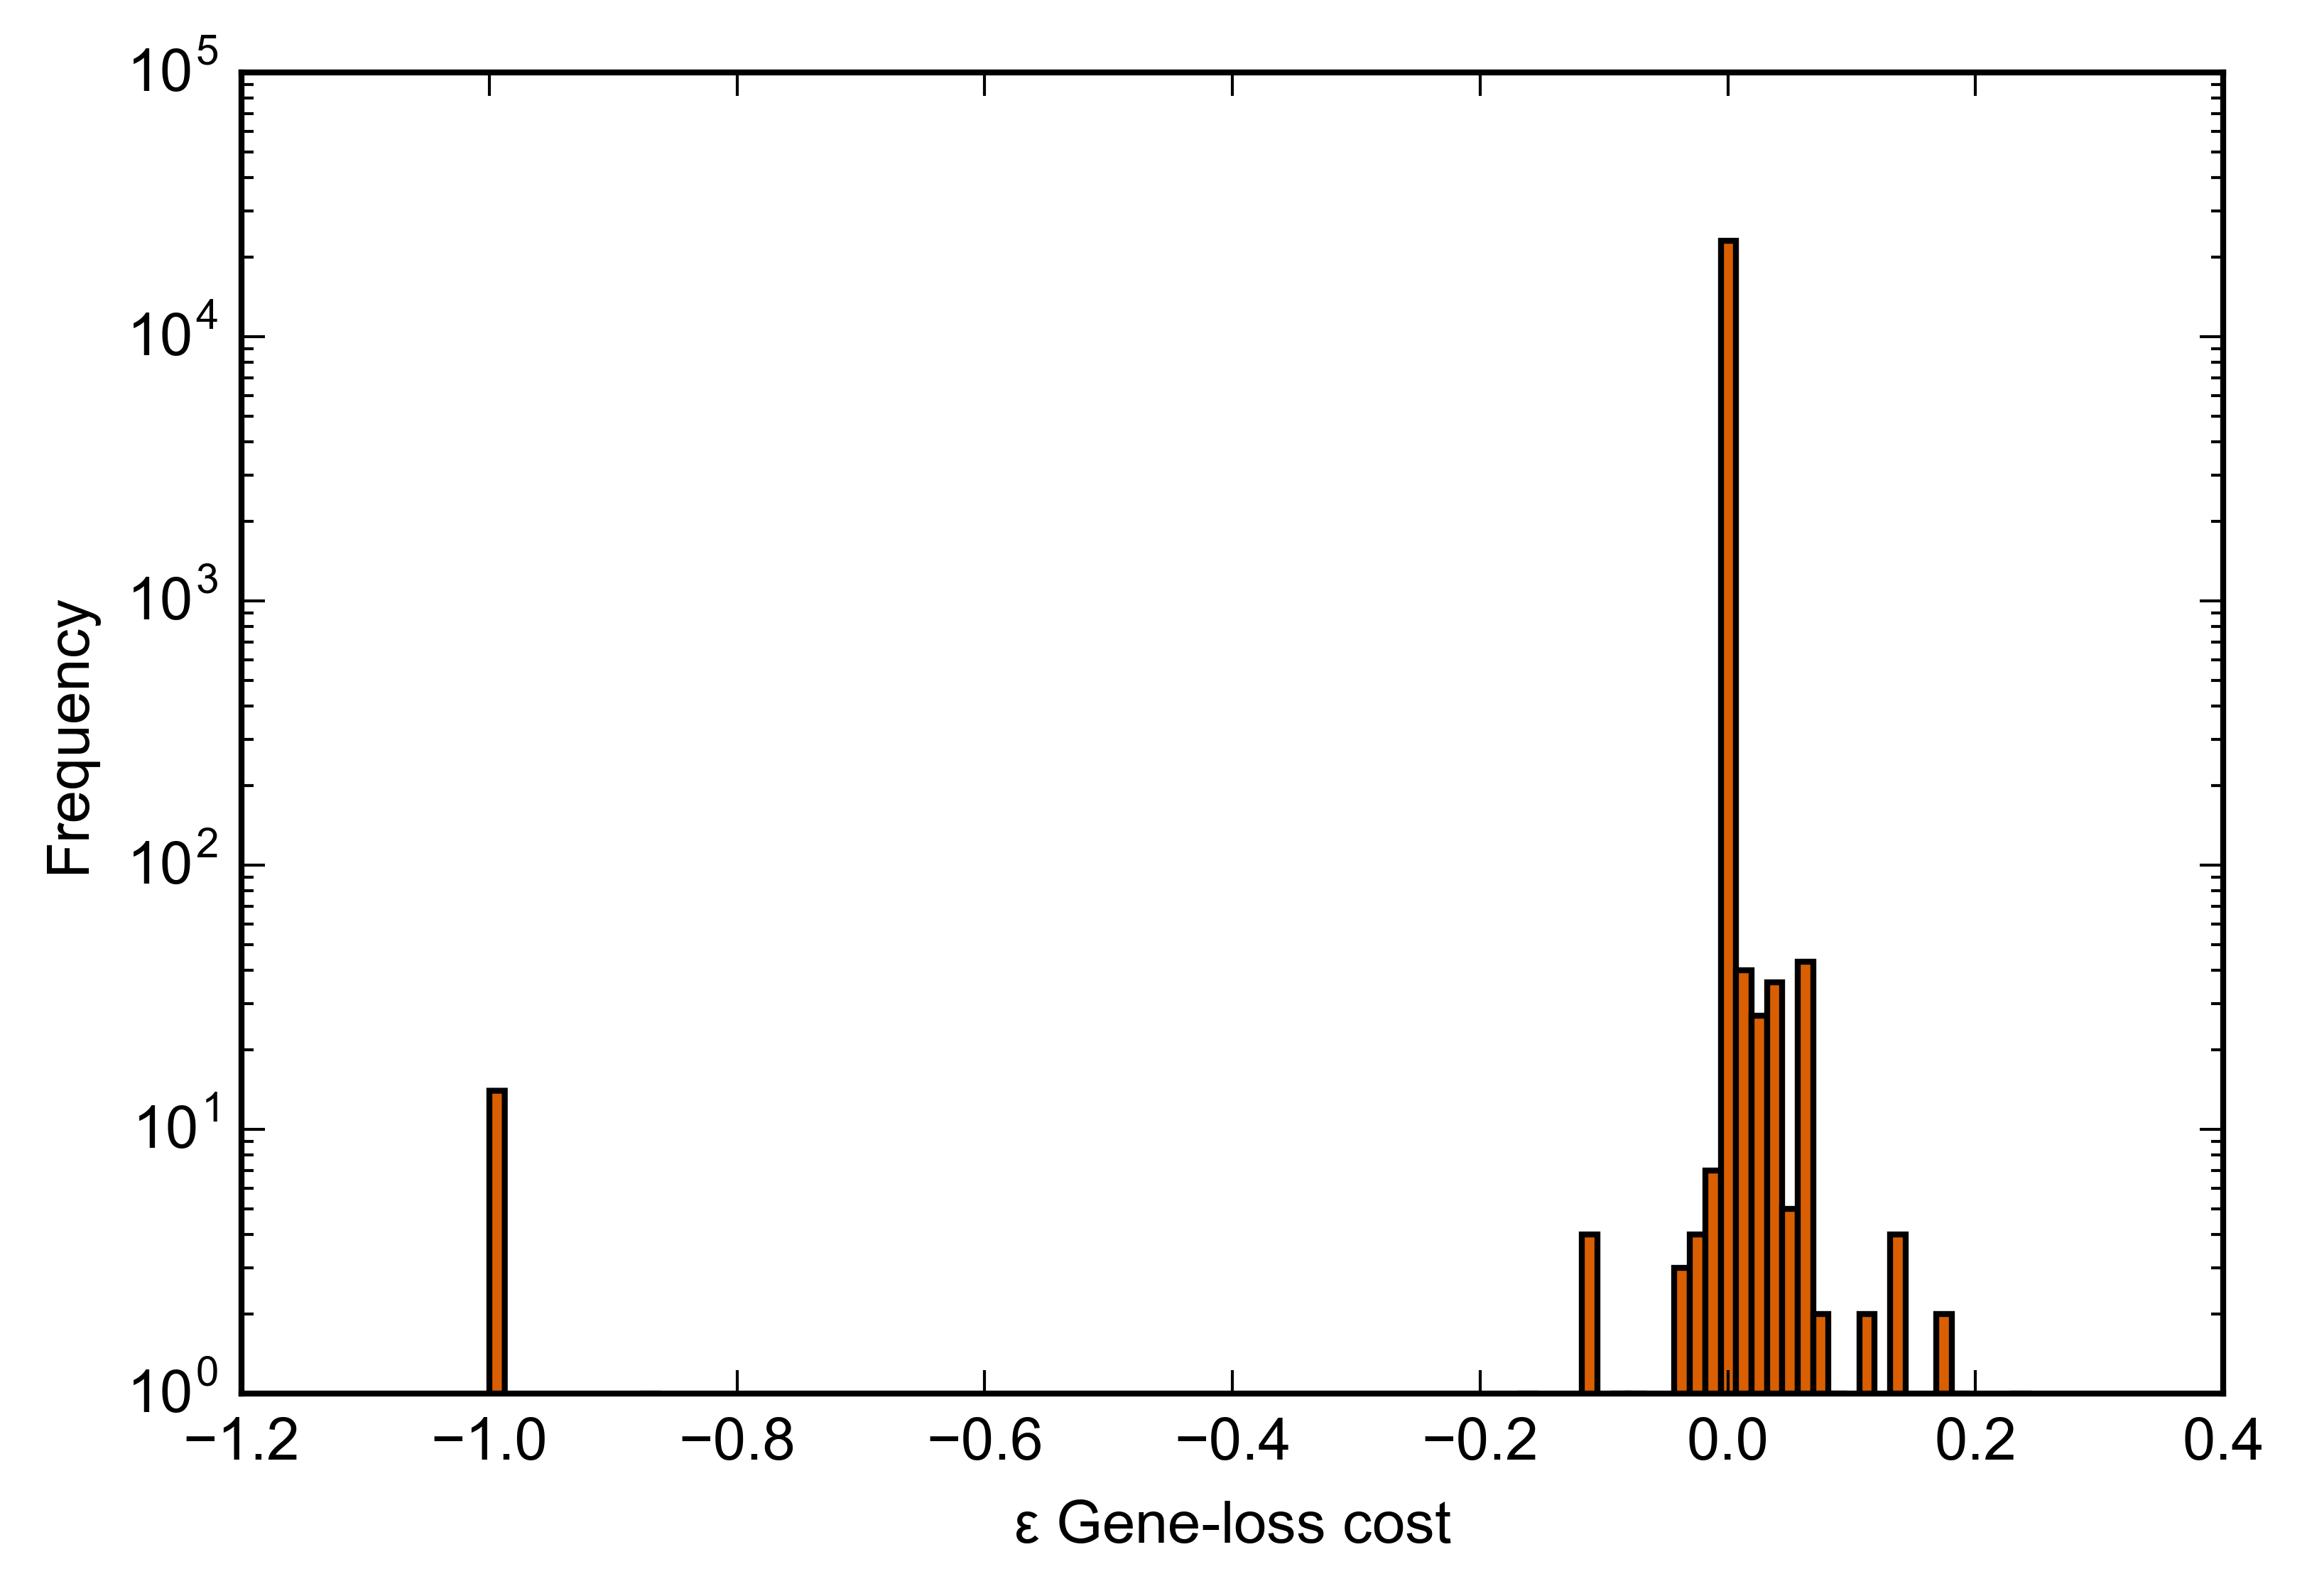

In [11]:
results['epsilon_glc'].plot(kind='hist', bins=100, color='#d95f02')
plt.yscale('log')
plt.xlabel('$\epsilon$ Gene-loss cost')
plt.show()

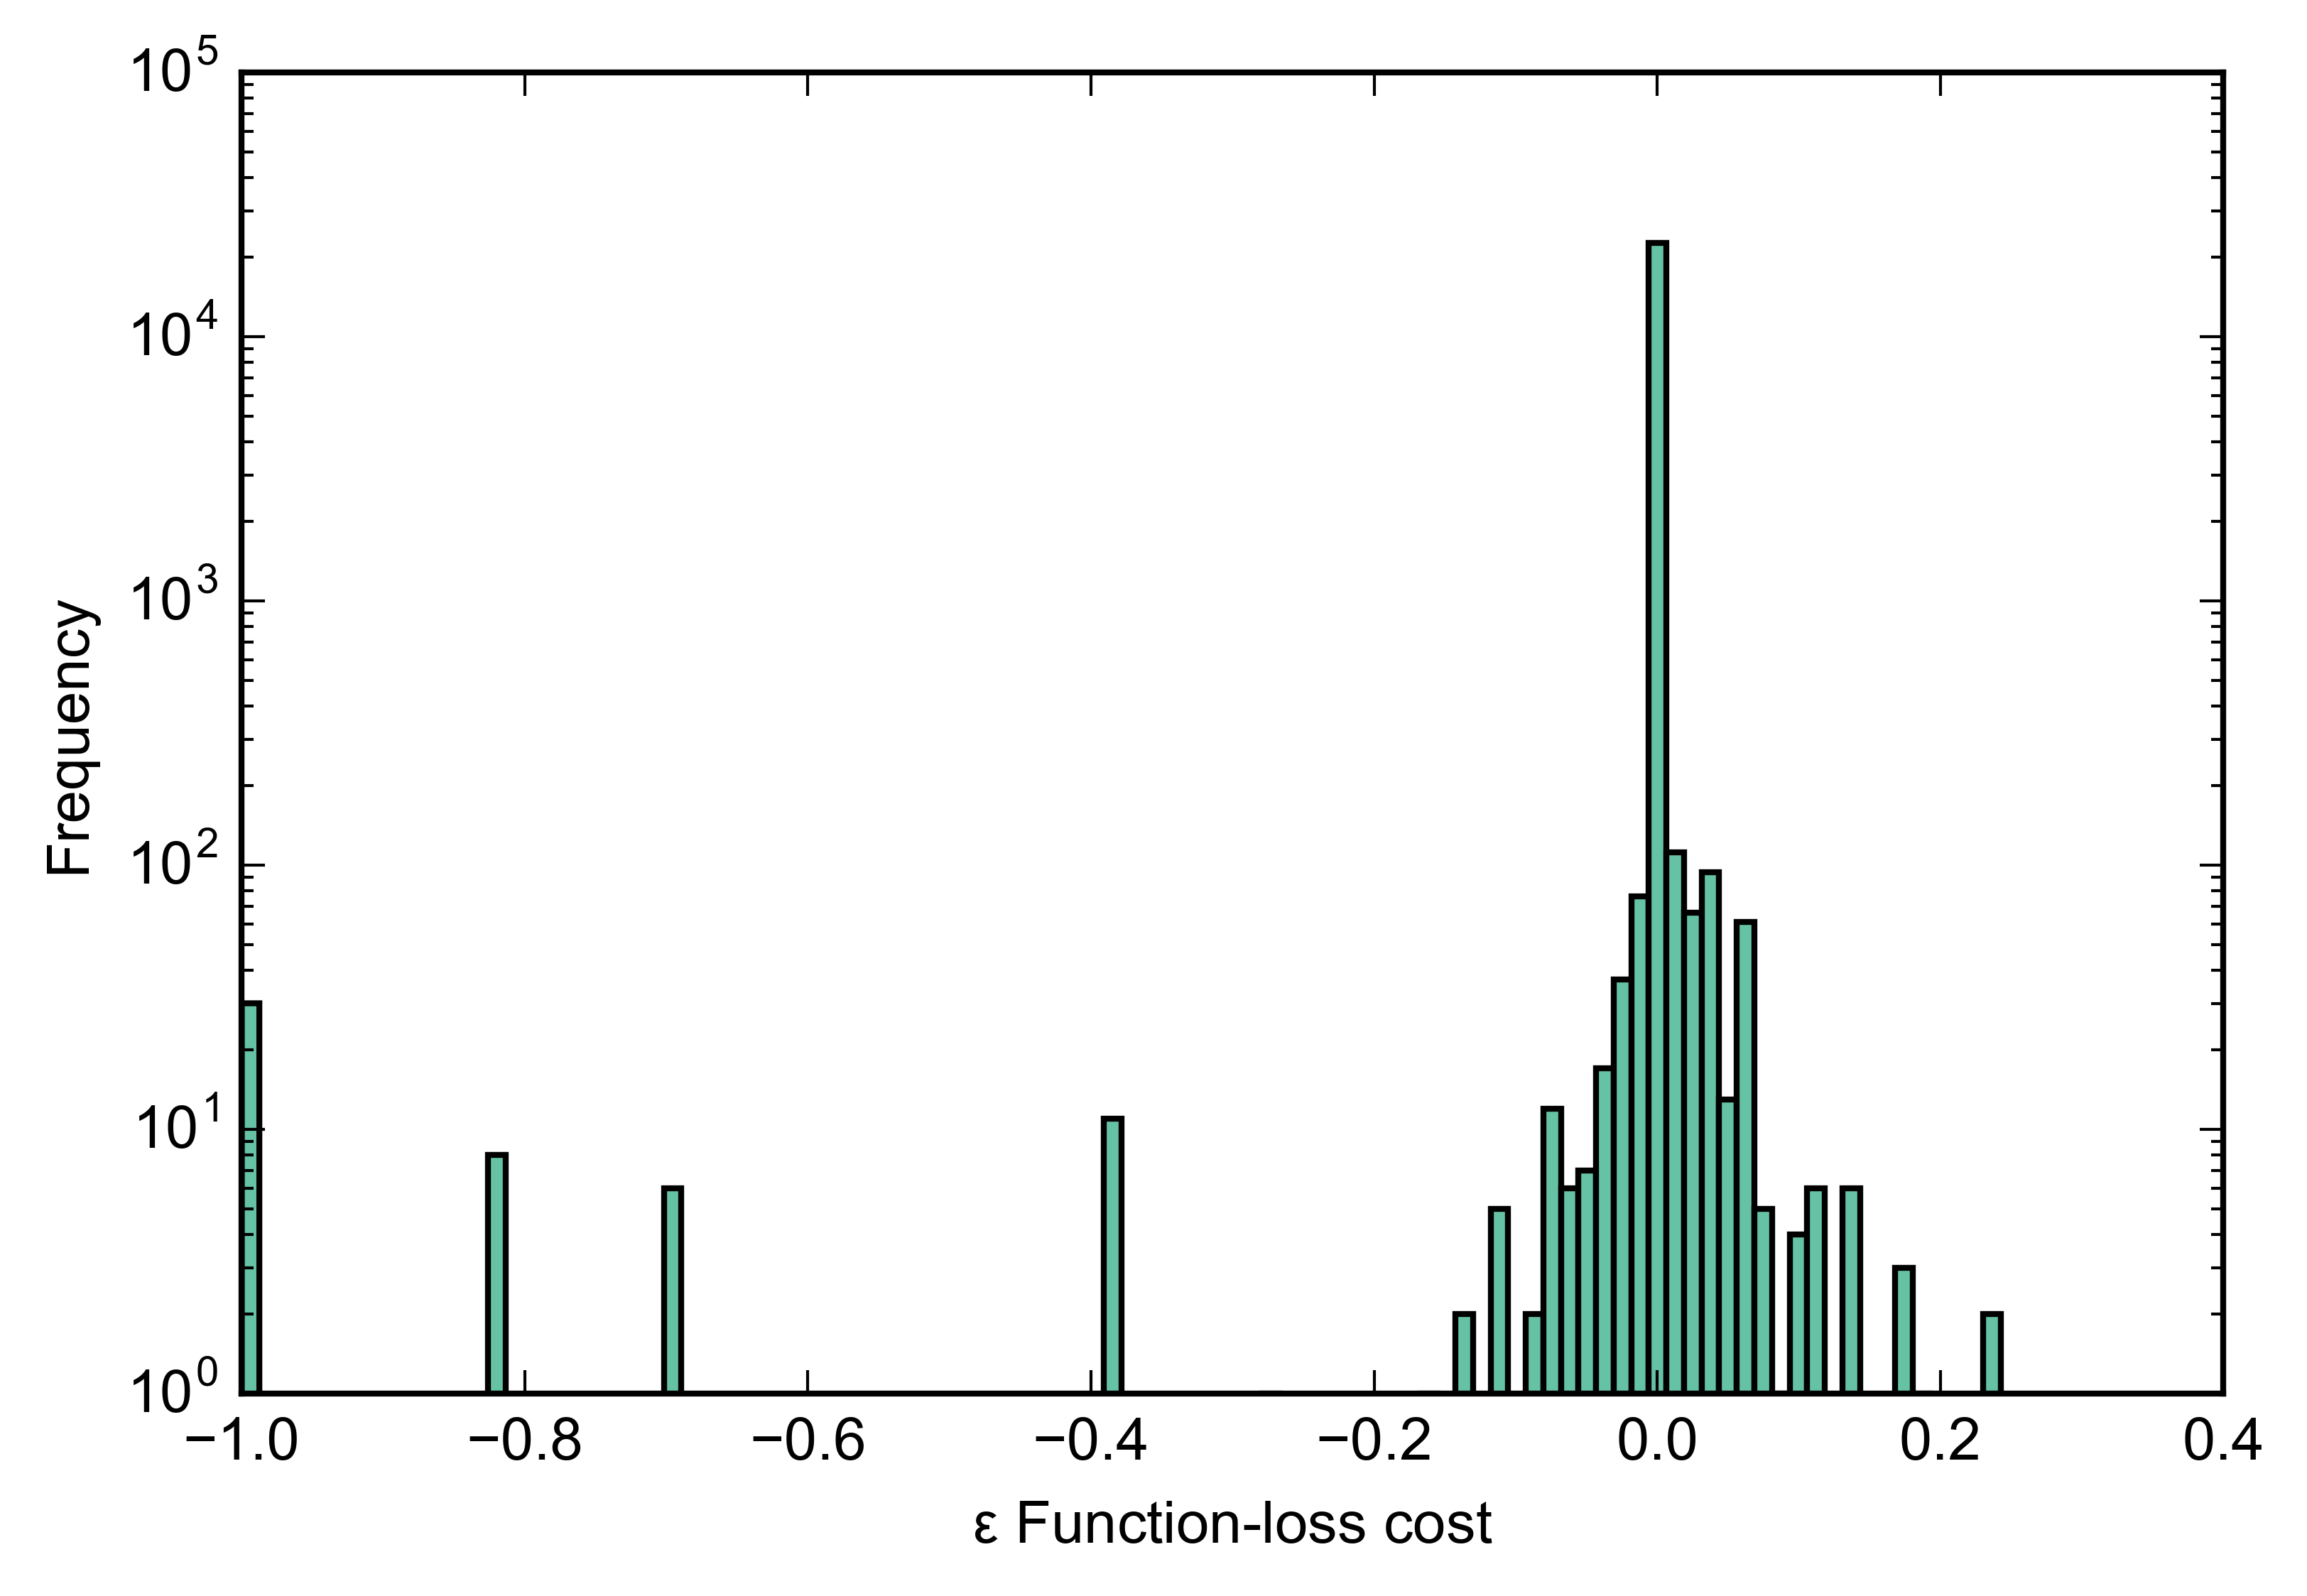

In [12]:
results['epsilon_flc'].plot(kind='hist', bins=100, color='#66c2a5')
plt.yscale('log')
plt.xlabel('$\epsilon$ Function-loss cost')
plt.show()

In [13]:
def get_counts(results, fbaCut):
    """
    
    Args:
        results (DataFrame):
        fbaCut (float): 
        
    Returns:
        dict:
        dict:
    
    """
    glcCounts = {}
    flcCounts = {}
    glcCounts['positive'] = {'positive': results[(results['experiment'] == 'positive') & 
                                               (results['epsilon_glc'] > fbaCut)].shape[0],
                            'negative': results[(results['experiment'] == 'positive') &
                                                (results['epsilon_glc'] < -fbaCut)].shape[0],
                            'non-interacting': results[(results['experiment'] == 'positive') &
                                                       (results['epsilon_glc'] < fbaCut) &
                                                       (results['epsilon_glc'] >= -fbaCut)].shape[0]
                            }
    glcCounts['negative'] = {'positive': results[(results['experiment'] == 'negative') & 
                                               (results['epsilon_glc'] > fbaCut)].shape[0],
                            'negative': results[(results['experiment'] == 'negative') &
                                                (results['epsilon_glc'] < -fbaCut)].shape[0],
                            'non-interacting': results[(results['experiment'] == 'negative') &
                                                       (results['epsilon_glc'] < fbaCut) &
                                                       (results['epsilon_glc'] >= -fbaCut)].shape[0]
                            }
    glcCounts['non-interacting'] = {'positive': results[(results['experiment'] == 'none') & 
                                               (results['epsilon_glc'] > fbaCut)].shape[0],
                            'negative': results[(results['experiment'] == 'none') &
                                                (results['epsilon_glc'] < -fbaCut)].shape[0],
                            'non-interacting': results[(results['experiment'] == 'none') &
                                                       (results['epsilon_glc'] < fbaCut) &
                                                       (results['epsilon_glc'] >= -fbaCut)].shape[0]
                            }
    flcCounts['positive'] = {'positive': results[(results['experiment'] == 'positive') & 
                                                (results['epsilon_flc'] > fbaCut)].shape[0],
                             'negative': results[(results['experiment'] == 'positive') &
                                                 (results['epsilon_flc'] < -fbaCut)].shape[0],
                             'non-interacting': results[(results['experiment'] == 'positive') &
                                                        (results['epsilon_flc'] < fbaCut) &
                                                        (results['epsilon_flc'] >= -fbaCut)].shape[0]
                            }
    flcCounts['negative'] = {'positive': results[(results['experiment'] == 'negative') & 
                                               (results['epsilon_flc'] > fbaCut)].shape[0],
                            'negative': results[(results['experiment'] == 'negative') &
                                                (results['epsilon_flc'] < -fbaCut)].shape[0],
                            'non-interacting': results[(results['experiment'] == 'negative') &
                                                       (results['epsilon_flc'] < fbaCut) &
                                                       (results['epsilon_flc'] >= -fbaCut)].shape[0]
                            }
    flcCounts['non-interacting'] = {'positive': results[(results['experiment'] == 'none') & 
                                               (results['epsilon_flc'] > fbaCut)].shape[0],
                            'negative': results[(results['experiment'] == 'none') &
                                                (results['epsilon_flc'] < -fbaCut)].shape[0],
                            'non-interacting': results[(results['experiment'] == 'none') &
                                                       (results['epsilon_flc'] < fbaCut) &
                                                       (results['epsilon_flc'] >= -fbaCut)].shape[0]
                            }
    return glcCounts, flcCounts

In [14]:
def six_pie_charts(glcCounts, flcCounts):
    """A figure containing the pie charts summarizing the genetic interaction prediction. 
    """
    headingFontSize = 12
    fig, axarr = plt.subplots(2, 3)
    fig.set_figheight(5.)
    fig.set_figwidth(7.5)
    fspct = 12
    totalNegative = sum(glcCounts['negative'].values())
    totalPositive = sum(glcCounts['positive'].values())
    totalNonInteracting = sum(glcCounts['non-interacting'].values())
    title = axarr[0,0].set_title('Synergistic (%d)' % totalNegative, fontsize=headingFontSize)
    titleOffset = 0.00
    title.set_position((title.get_position()[0], title.get_position()[1] + titleOffset))
    axarr[0,0].pie([flcCounts['negative']['negative'], flcCounts['negative']['positive'], 
                    flcCounts['negative']['non-interacting']], colors=['red', 'blue', 'lightgrey'],
                   explode=[0.2, 0., 0.], autopct='%.0f%%', pctdistance=1.25, 
                   textprops={'fontsize': fspct})
    axarr[1,0].pie([glcCounts['negative']['negative'], glcCounts['negative']['positive'], 
                    glcCounts['negative']['non-interacting']], colors=['red', 'blue', 'lightgrey'],
                   explode=[0.2, 0., 0.], autopct='%.0f%%', pctdistance=1.25,
                  textprops={'fontsize': fspct})
    title = axarr[0,1].set_title('Antagonistic (%d)' % totalPositive, fontsize=headingFontSize)
    title.set_position((title.get_position()[0], title.get_position()[1] + titleOffset))
    axarr[0,1].pie([flcCounts['positive']['negative'], flcCounts['positive']['positive'], 
                    flcCounts['positive']['non-interacting']], colors=['red', 'blue', 'lightgrey'],
                   explode=[0., 0.2, 0.], autopct='%.0f%%', pctdistance=1.25,
                  textprops={'fontsize': fspct})
    axarr[1,1].pie([glcCounts['positive']['negative'], glcCounts['positive']['positive'], 
                    glcCounts['positive']['non-interacting']], colors=['red', 'blue', 'lightgrey'],
                    explode=[0., 0.2, 0.], autopct='%.0f%%', pctdistance=1.25,
                  textprops={'fontsize': fspct})
    title = axarr[0,2].set_title('Non-interacting (%d)' % totalNonInteracting, fontsize=headingFontSize)
    title.set_position((title.get_position()[0], title.get_position()[1] + titleOffset))
    axarr[0,2].pie([flcCounts['non-interacting']['negative'], flcCounts['non-interacting']['positive'], 
                    flcCounts['non-interacting']['non-interacting']], colors=['red', 'blue', 'lightgrey'],
                   explode=[0.0, 0., 0.0], autopct='%.0f%%', pctdistance=1.2,
                  textprops={'fontsize': fspct})
    axarr[1,2].pie([glcCounts['non-interacting']['negative'], glcCounts['non-interacting']['positive'], 
                    glcCounts['non-interacting']['non-interacting']], colors=['red', 'blue', 'lightgrey'],
                    explode=[0.0, 0., 0.0], autopct='%.0f%%', pctdistance=1.2,
                  textprops={'fontsize': fspct})
    # moving some of the percent numbers manually, 
    #   there's probably a better way to do this
    oldPos = axarr[1, 2].texts[1].get_position() 
    axarr[1, 2].texts[1].set_position((oldPos[0], oldPos[1] + 0.2))
    oldPos = axarr[1, 2].texts[3].get_position() 
    axarr[1, 2].texts[3].set_position((oldPos[0], oldPos[1] - 0.2))
    oldPos = axarr[1, 2].texts[5].get_position() 
    axarr[1, 2].texts[5].set_position((oldPos[0] + 0.7, oldPos[1] - 0.15))
    oldPos = axarr[1, 0].texts[5].get_position() 
    axarr[1, 0].texts[5].set_position((oldPos[0] + 0.7, oldPos[1]))
    oldPos = axarr[1, 1].texts[5].get_position() 
    axarr[1, 1].texts[5].set_position((oldPos[0] + 0.7, oldPos[1]))
    oldPos = axarr[0, 0].texts[5].get_position() 
    axarr[0, 0].texts[5].set_position((oldPos[0] + 0.6, oldPos[1] + 0.5))
    oldPos = axarr[0, 1].texts[5].get_position() 
    axarr[0, 1].texts[5].set_position((oldPos[0] + 0.6, oldPos[1] + 0.5))
    oldPos = axarr[0, 2].texts[5].get_position() 
    axarr[0, 2].texts[5].set_position((oldPos[0] + 0.6, oldPos[1] + 0.3))
    fig.text(0.07,0.3, 'Redundant\nisoenzymes', fontsize=12, horizontalalignment='center')
    fig.text(0.055,0.73, 'Non-redundant\nisoenzymes', fontsize=12, horizontalalignment='center')
    p1 = mpatches.Patch(color='red', label='Synergistic')
    p2 = mpatches.Patch(color='blue', label='Antagonistic')
    p3 = mpatches.Patch(color='lightgrey', label='Non-interacting')
    fig.legend([p1, p2, p3], ['Synergistic', 'Antagonistic', 'Non-interacting'], 
               title='FBA predictions', fontsize=9,
               fancybox=True, loc=(0., 0.4))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

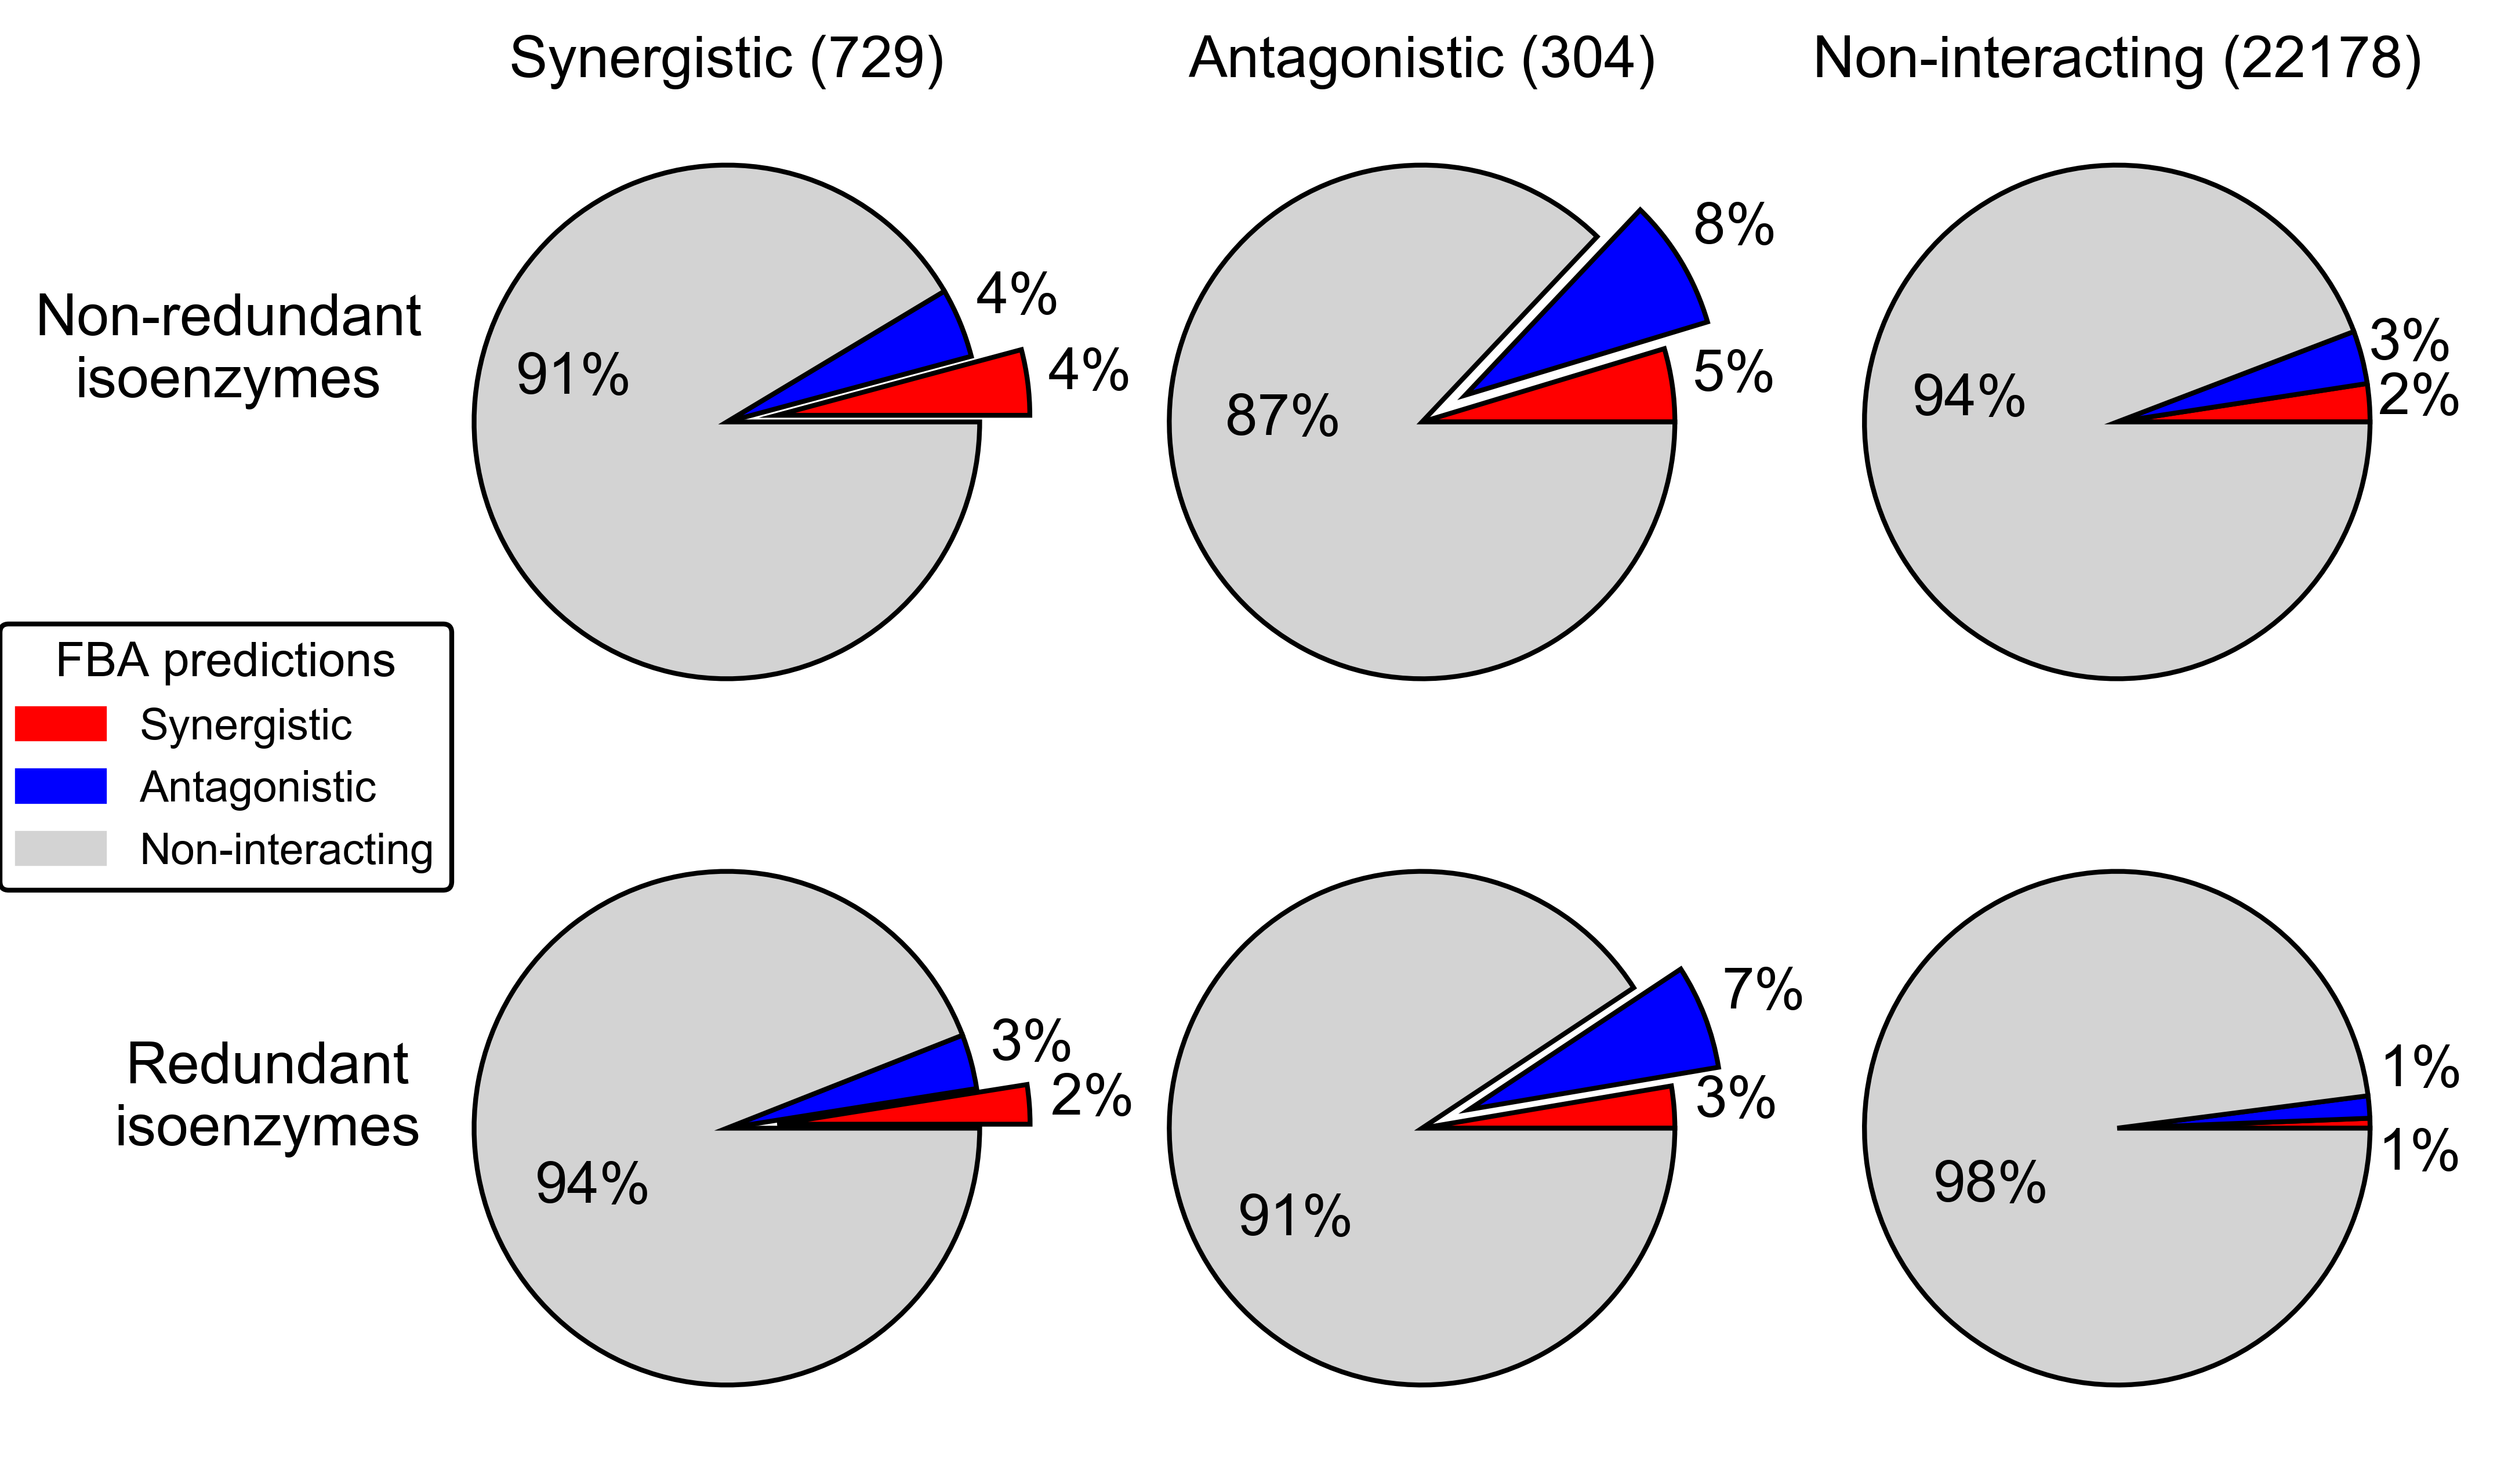

In [15]:
figDir = '../figures/yeast_7.6'
fbaCut = 0.0001
glcCounts, flcCounts = get_counts(results, fbaCut)
six_pie_charts(glcCounts, flcCounts)
plt.savefig(os.path.join(figDir, 'latest_revision_figure4.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figure4.eps'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figure4.svg'), bbox_inches='tight')

In [16]:
# check on genes that are correctly predicted with function-loss and not gene-loss
fbaCut = 0.0001
newTP = results[((results['epsilon_flc'] < -fbaCut) & 
                (results['epsilon_glc'] > -fbaCut) & 
                (results['experiment'] == 'negative')) | 
                ((results['epsilon_flc'] > fbaCut) & 
                (results['epsilon_glc'] < fbaCut) & 
                (results['experiment'] == 'positive'))].copy()
# create map of gene to is_isoenzyme
isIsoenzyme = {}
for gene in model.genes:
    isIsoenzyme[gene.id] = any(['or' in r.gene_reaction_rule for r in gene.reactions])
newTP['contains_isoenzyme'] = newTP['geneA'].map(isIsoenzyme) | newTP['geneB'].map(isIsoenzyme)
print newTP['contains_isoenzyme'].sum(), 'out of', newTP.shape[0],
print 'newly correctly classified negative interactions contain isoenzymes'

other = results[(((results['epsilon_flc'] >= -fbaCut) | 
                (results['epsilon_glc'] < -fbaCut)) & 
                (results['experiment'] == 'negative')) |
                (((results['epsilon_flc'] <= fbaCut) | 
                (results['epsilon_glc'] > fbaCut)) & 
                (results['experiment'] == 'positive'))].copy()
other['contains_isoenzyme'] = other['geneA'].map(isIsoenzyme) | other['geneB'].map(isIsoenzyme)
print other['contains_isoenzyme'].sum(), 'out of', other.shape[0],
print 'for comparison'

22 out of 22 newly correctly classified negative interactions contain isoenzymes
715 out of 1011 for comparison


In [17]:
from scipy.stats import fisher_exact



def test_significance(counts):
    negResults = fisher_exact([[counts['negative']['negative'], 
                     counts['negative']['positive'] + counts['negative']['non-interacting']], 
                    [counts['positive']['negative'] + counts['non-interacting']['negative'],
                     counts['positive']['positive'] + counts['non-interacting']['non-interacting'] + 
                     counts['positive']['non-interacting'] + counts['non-interacting']['positive']]])
    posResults = fisher_exact([[counts['positive']['positive'], 
                     counts['positive']['negative'] + counts['positive']['non-interacting']], 
                    [counts['negative']['positive'] + counts['non-interacting']['positive'],
                     counts['negative']['negative'] + counts['non-interacting']['non-interacting'] + 
                     counts['negative']['non-interacting'] + counts['non-interacting']['negative']]])
    print 'Negative genetic interactions, odds ratio = %.2f, p-value = %.3e' % negResults
    print 'Postiive genetic interactions, odds ratio = %.2f, p-value = %.3e' % posResults

print 'gene-loss'
test_significance(glcCounts)
print 'function loss'
test_significance(flcCounts)

gene-loss
Negative genetic interactions, odds ratio = 3.90, p-value = 3.973e-06
Postiive genetic interactions, odds ratio = 4.75, p-value = 5.514e-08
function loss
Negative genetic interactions, odds ratio = 1.73, p-value = 7.108e-03
Postiive genetic interactions, odds ratio = 2.57, p-value = 7.824e-05


In [18]:
from scipy.stats import fisher_exact

def hypothesis_test(counts, cat):
    if cat == 'positive':
        otherCat = 'negative'
    elif cat == 'negative':
        otherCat = 'positive'
    tp = counts[cat][cat]
    tn = counts[otherCat][otherCat] + counts[otherCat]['non-interacting'] + \
          counts['non-interacting']['non-interacting'] + counts['non-interacting'][otherCat]
    fp = counts['non-interacting'][cat] + counts[otherCat][cat]
    fn = counts[cat][otherCat] + counts[cat]['non-interacting']
    contingency = [[tp, fp], [fn, tn]]
    print cat
    print contingency
    print 'odds-ratio: %.1f\np-value: %.1e' % fisher_exact(contingency)

print 'Gene-loss cost'
hypothesis_test(glcCounts, 'negative')
hypothesis_test(glcCounts, 'positive')
print '\nFunction-loss cost'
hypothesis_test(flcCounts, 'negative')
hypothesis_test(flcCounts, 'positive')

Gene-loss cost
negative
[[18, 145], [711, 22337]]
odds-ratio: 3.9
p-value: 4.0e-06
positive
[[20, 335], [284, 22572]]
odds-ratio: 4.7
p-value: 5.5e-08

Function-loss cost
negative
[[30, 544], [699, 21938]]
odds-ratio: 1.7
p-value: 7.1e-03
positive
[[25, 772], [279, 22135]]
odds-ratio: 2.6
p-value: 7.8e-05


In [19]:
def precision_recall(counts):
    def precision(counts, cat):
        if cat == 'positive':
            otherCat = 'negative'
        elif cat == 'negative':
            otherCat = 'positive'
        return float(counts[cat][cat]) / float(counts[cat][cat] + 
                                               counts[otherCat][cat] + 
                                               counts['non-interacting'][cat])
       
    def recall(counts, cat):
        if cat == 'positive':
            otherCat = 'negative'
        elif cat == 'negative':
            otherCat = 'positive'
        return float(counts[cat][cat]) / float(counts[cat][cat] + 
                                               counts[cat][otherCat] + 
                                               counts[cat]['non-interacting']) 
    
    precisionVals = {}
    precisionVals['negative'] = precision(counts, 'negative')
    precisionVals['positive'] = precision(counts, 'positive')
    recallVals = {}
    recallVals['negative'] = recall(counts, 'negative')
    recallVals['positive'] = recall(counts, 'positive')
    return precisionVals, recallVals
    

print 'Gene loss-cost'
precision_recall(glcCounts)
print 'Function loss-cost'
precision_recall(flcCounts)

Gene loss-cost
Function loss-cost


({'negative': 0.05226480836236934, 'positive': 0.03136762860727729},
 {'negative': 0.0411522633744856, 'positive': 0.08223684210526316})

In [20]:
epsilonVals = np.logspace(-4., -2.)
prGLC = [precision_recall(get_counts(results, i)[0]) for i in epsilonVals]
prGLCNeg = [(p['negative'], r['negative']) for p, r in prGLC]
prFLC = [precision_recall(get_counts(results, i)[1]) for i in epsilonVals]
prFLCNeg = [(p['negative'], r['negative']) for p, r in prFLC]
prGLCPos = [(p['positive'], r['positive']) for p, r in prGLC]
prFLCPos = [(p['positive'], r['positive']) for p, r in prFLC]

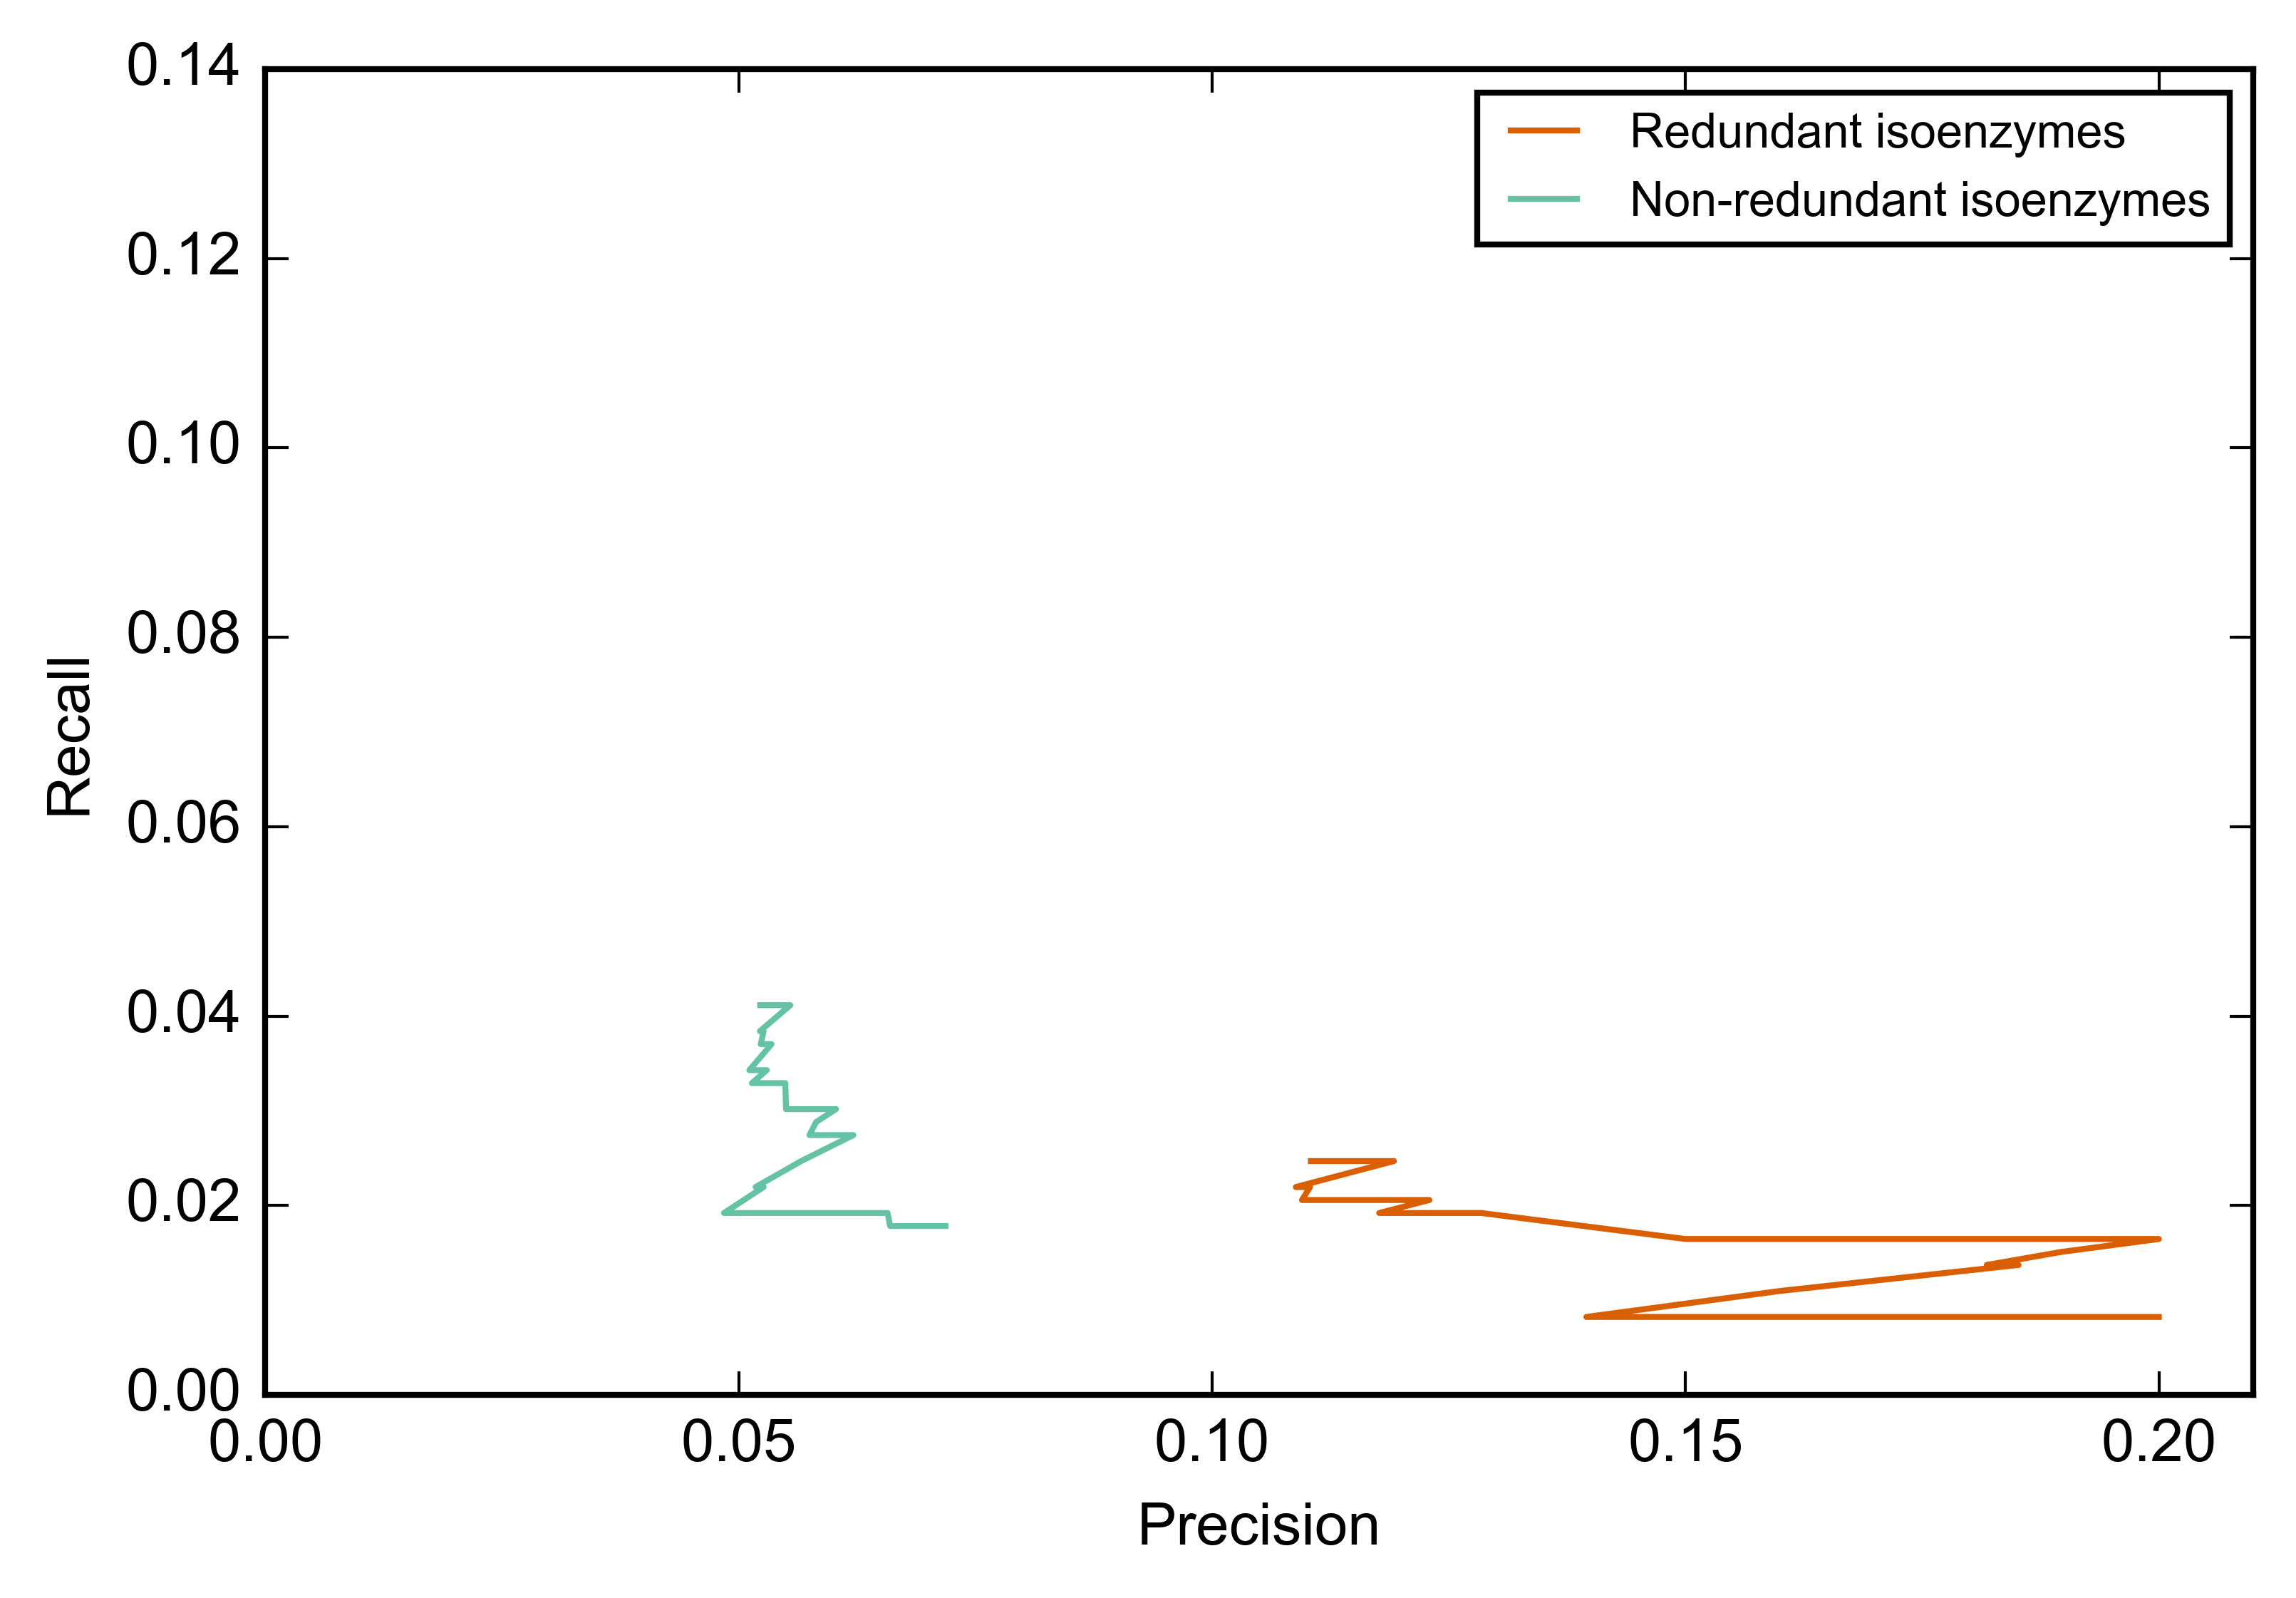

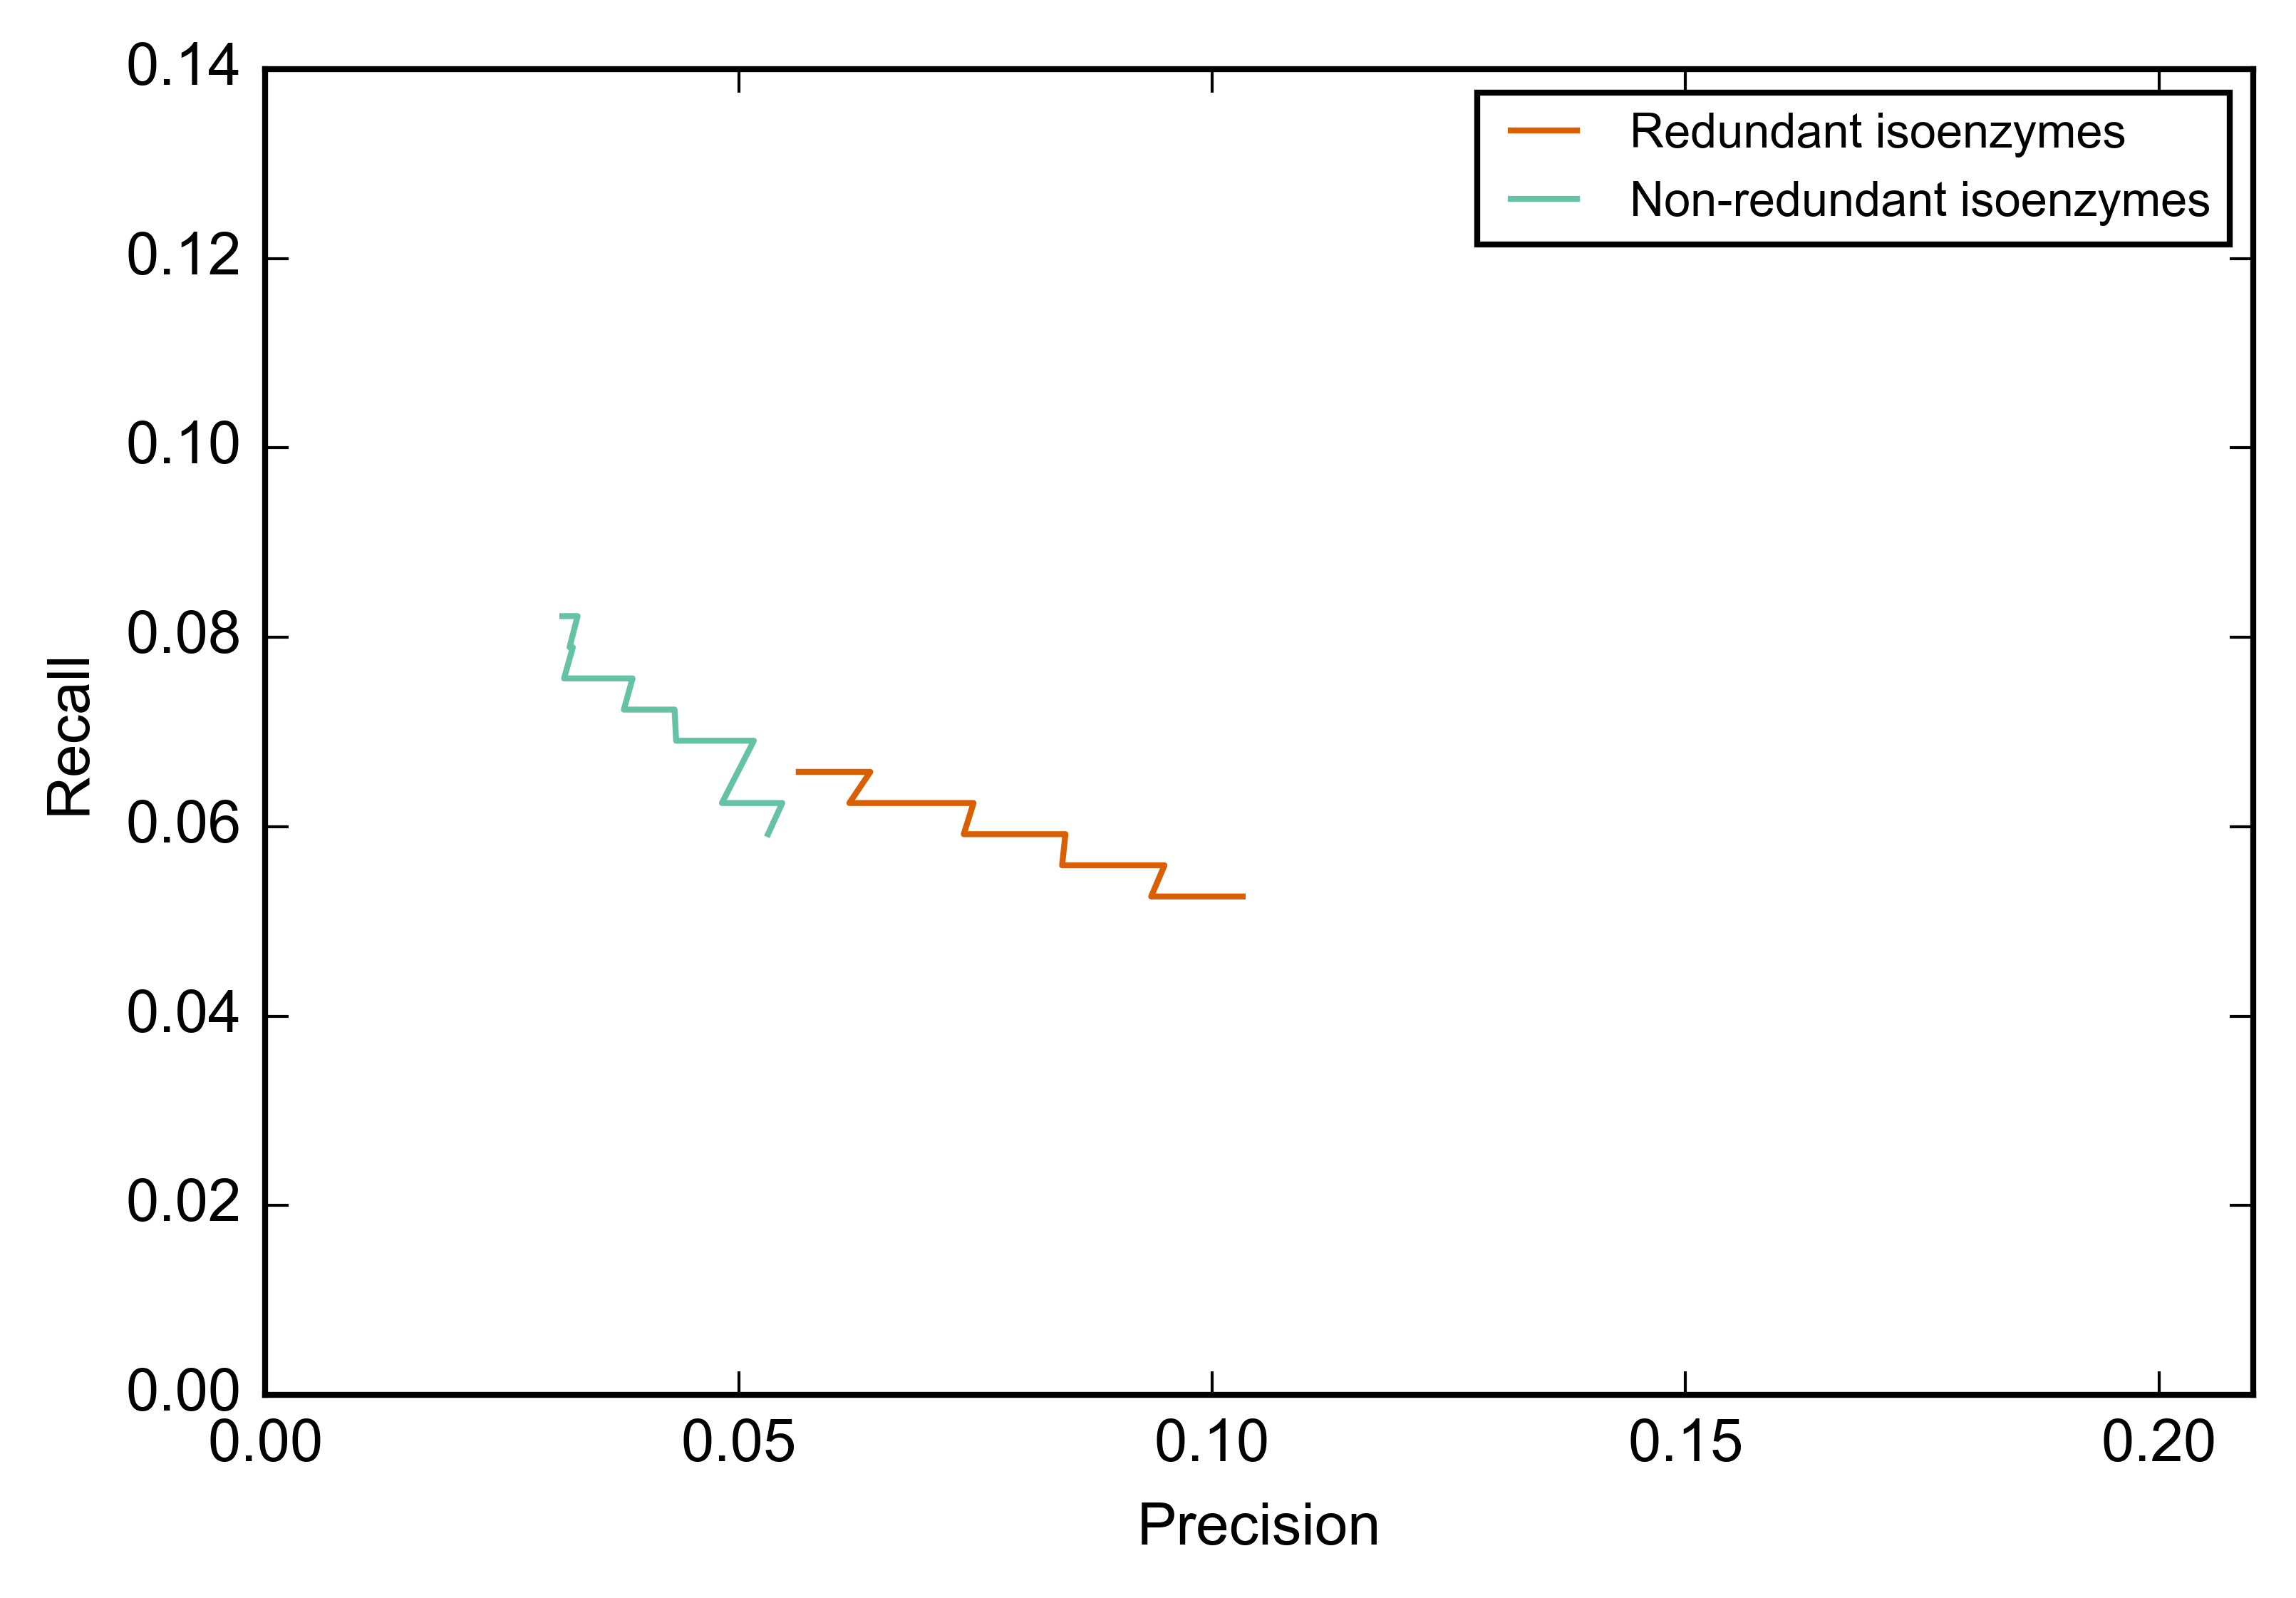

In [21]:
def precision_recall_curve(ax, prGLC, prFLC, drawLegend=True):
    ax.plot([i[0] for i in prGLC], [i[1] for i in prGLC], '-',
             label='Redundant isoenzymes', color='#d95f02')
    ax.plot([i[0] for i in prFLC], [i[1] for i in prFLC], '-',
             label='Non-redundant isoenzymes', color='#66c2a5')
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    ax.set_xlim((0., 0.21))
    ax.set_ylim((0., 0.14))
    if drawLegend:
        ax.legend(fontsize=8)

fig, ax = plt.subplots(1, 1)
precision_recall_curve(ax, prGLCNeg, prFLCNeg)
plt.show()
fig, ax = plt.subplots(1, 1)
precision_recall_curve(ax, prGLCPos, prFLCPos)
plt.show()

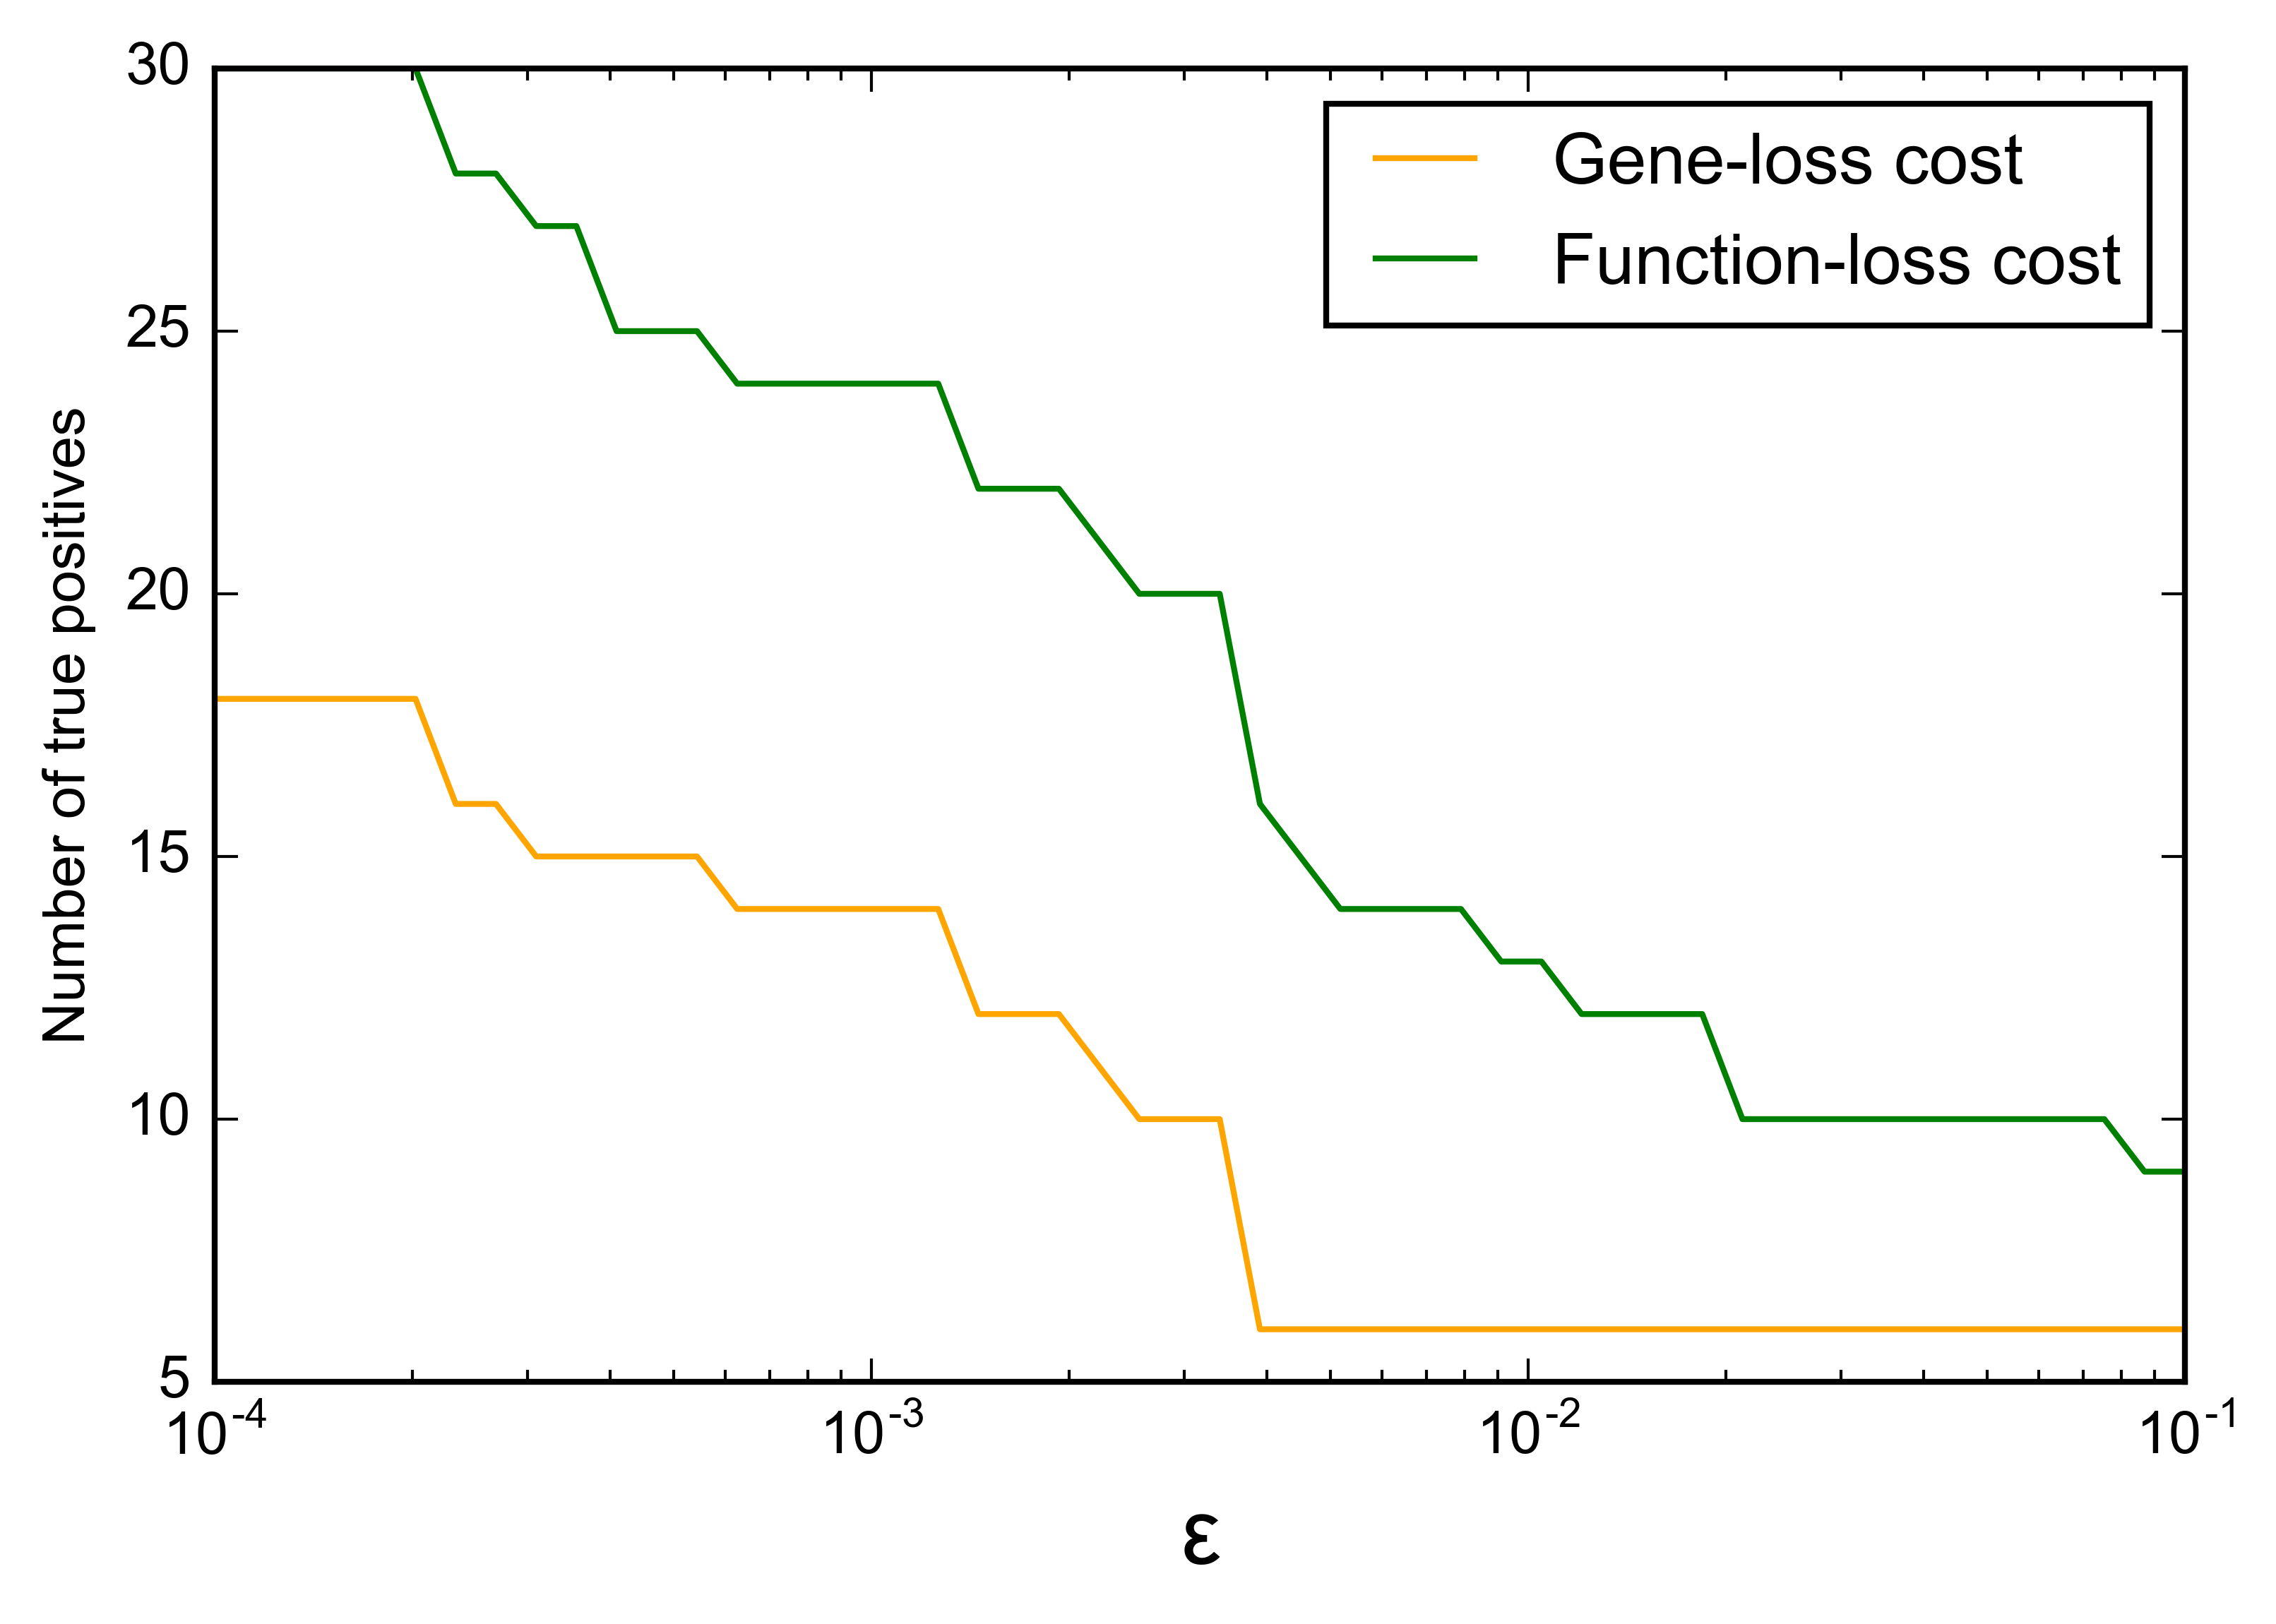

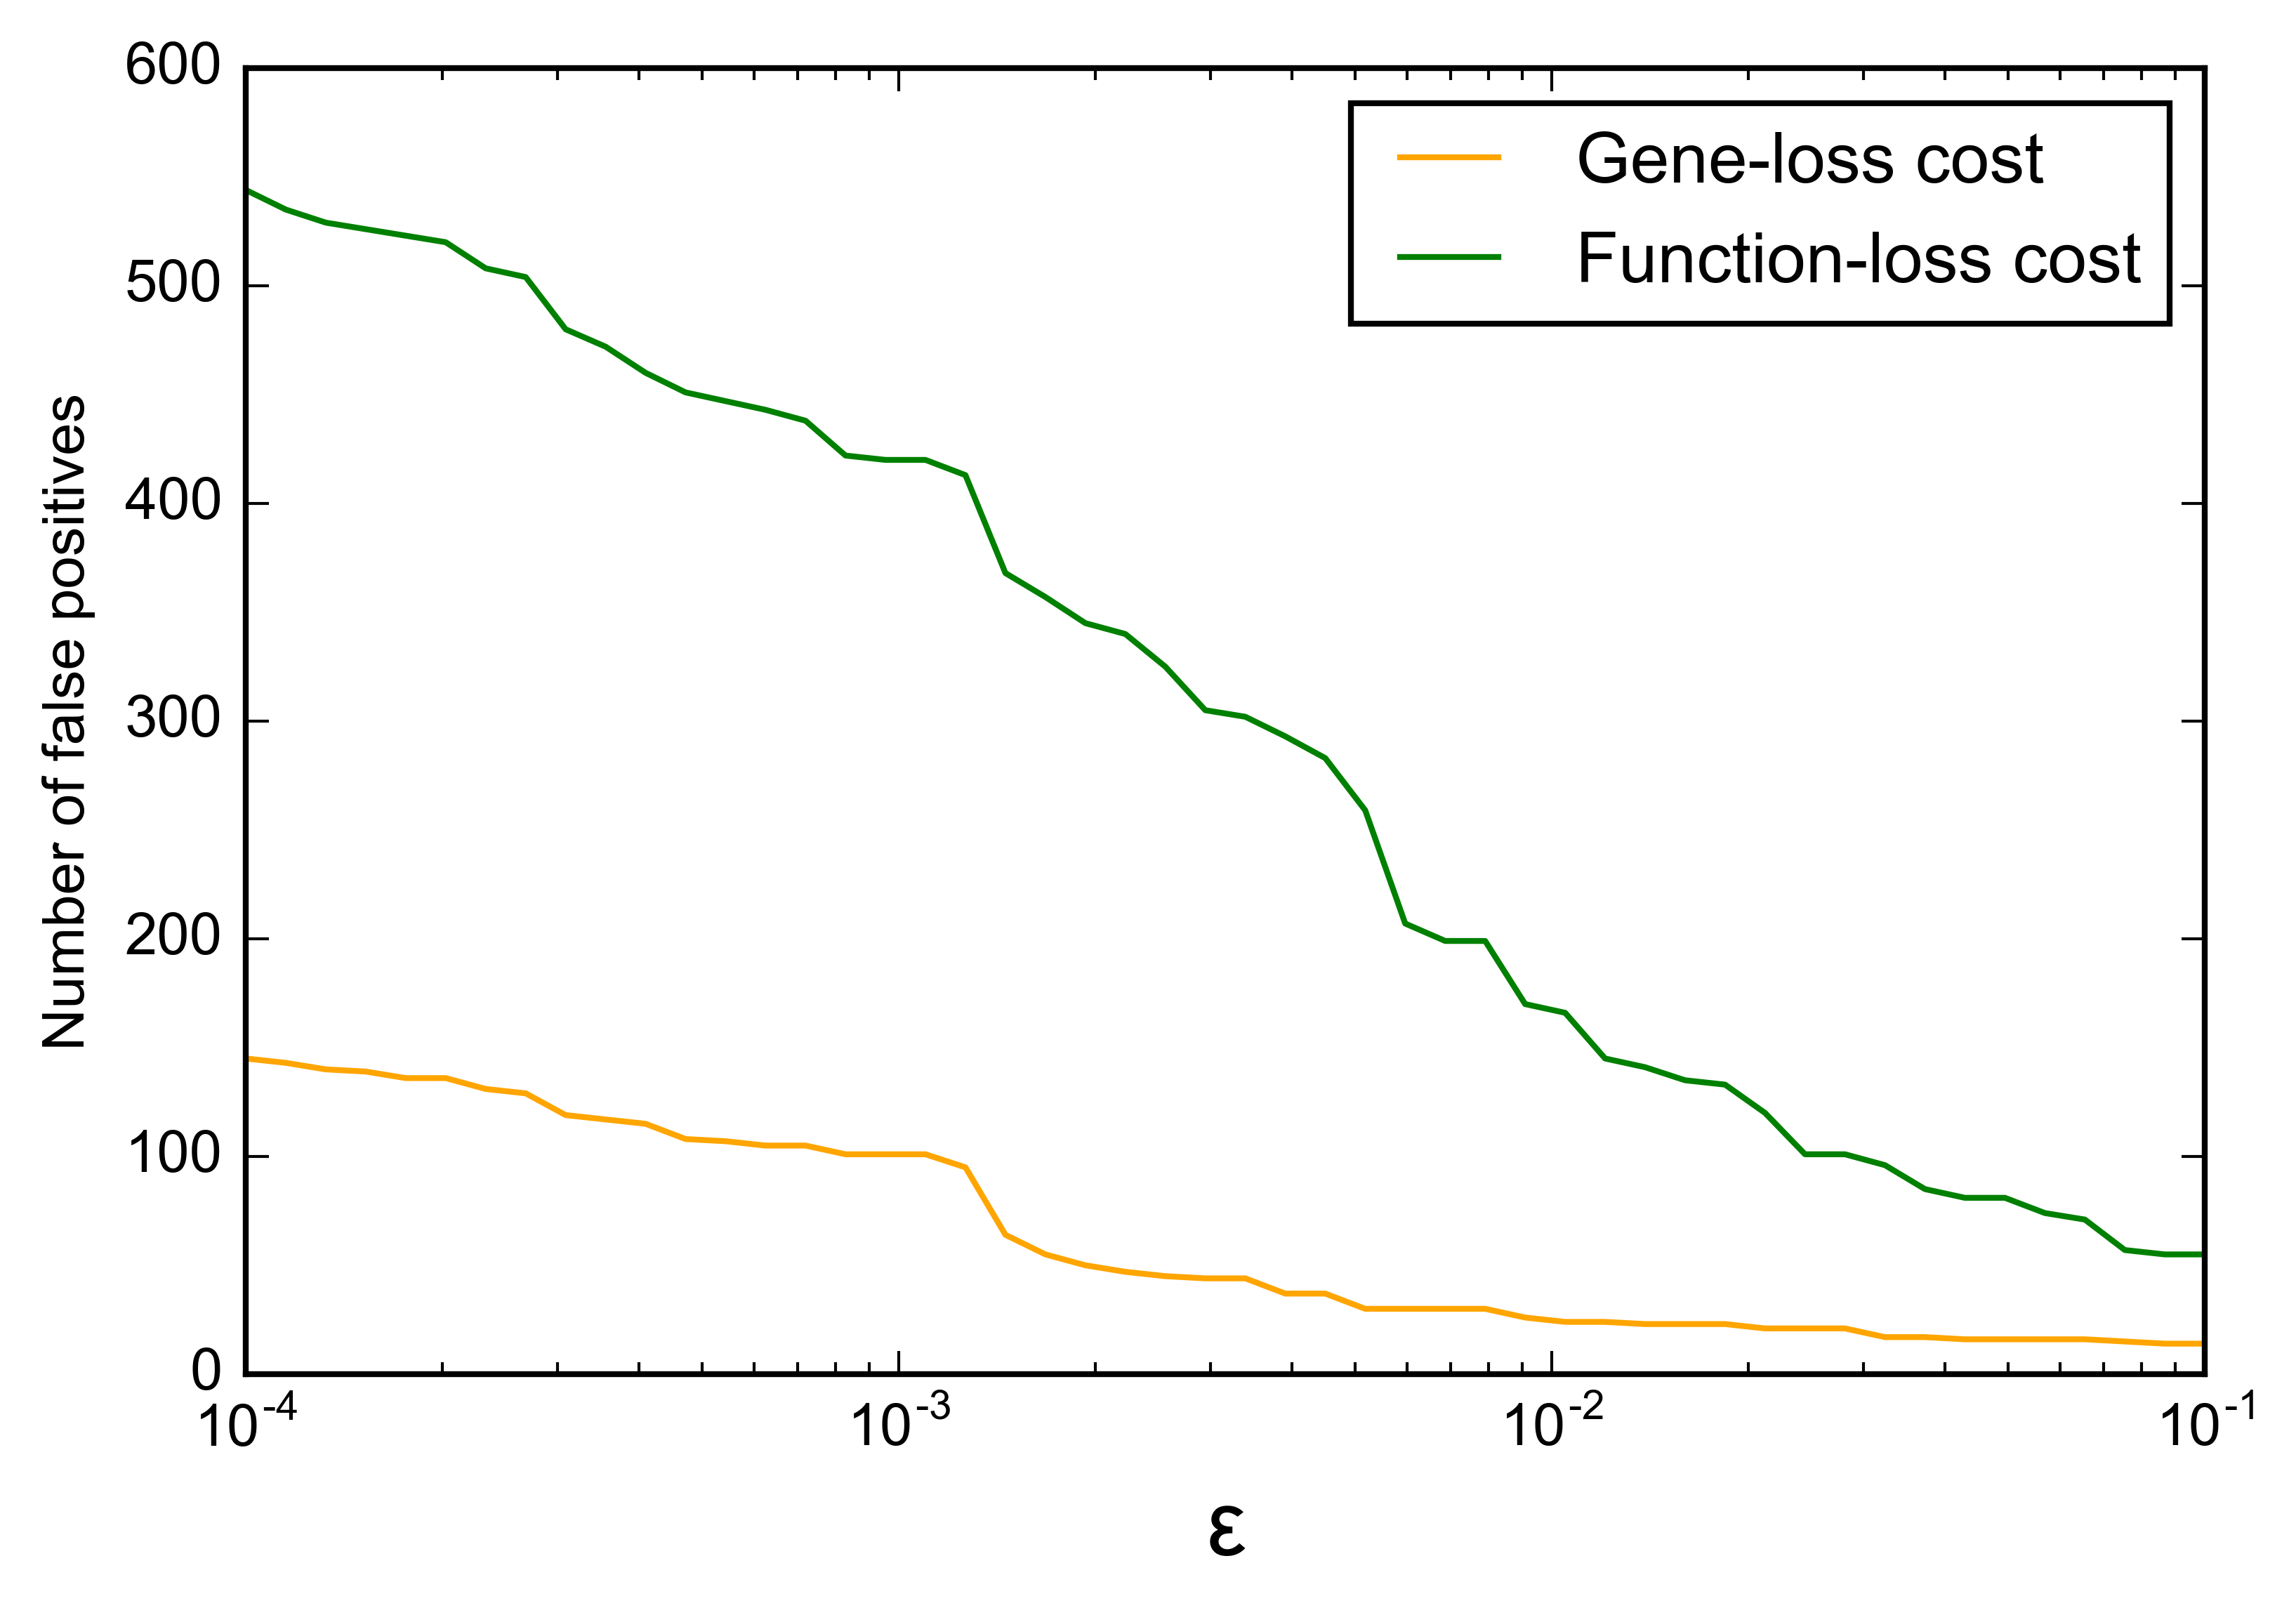

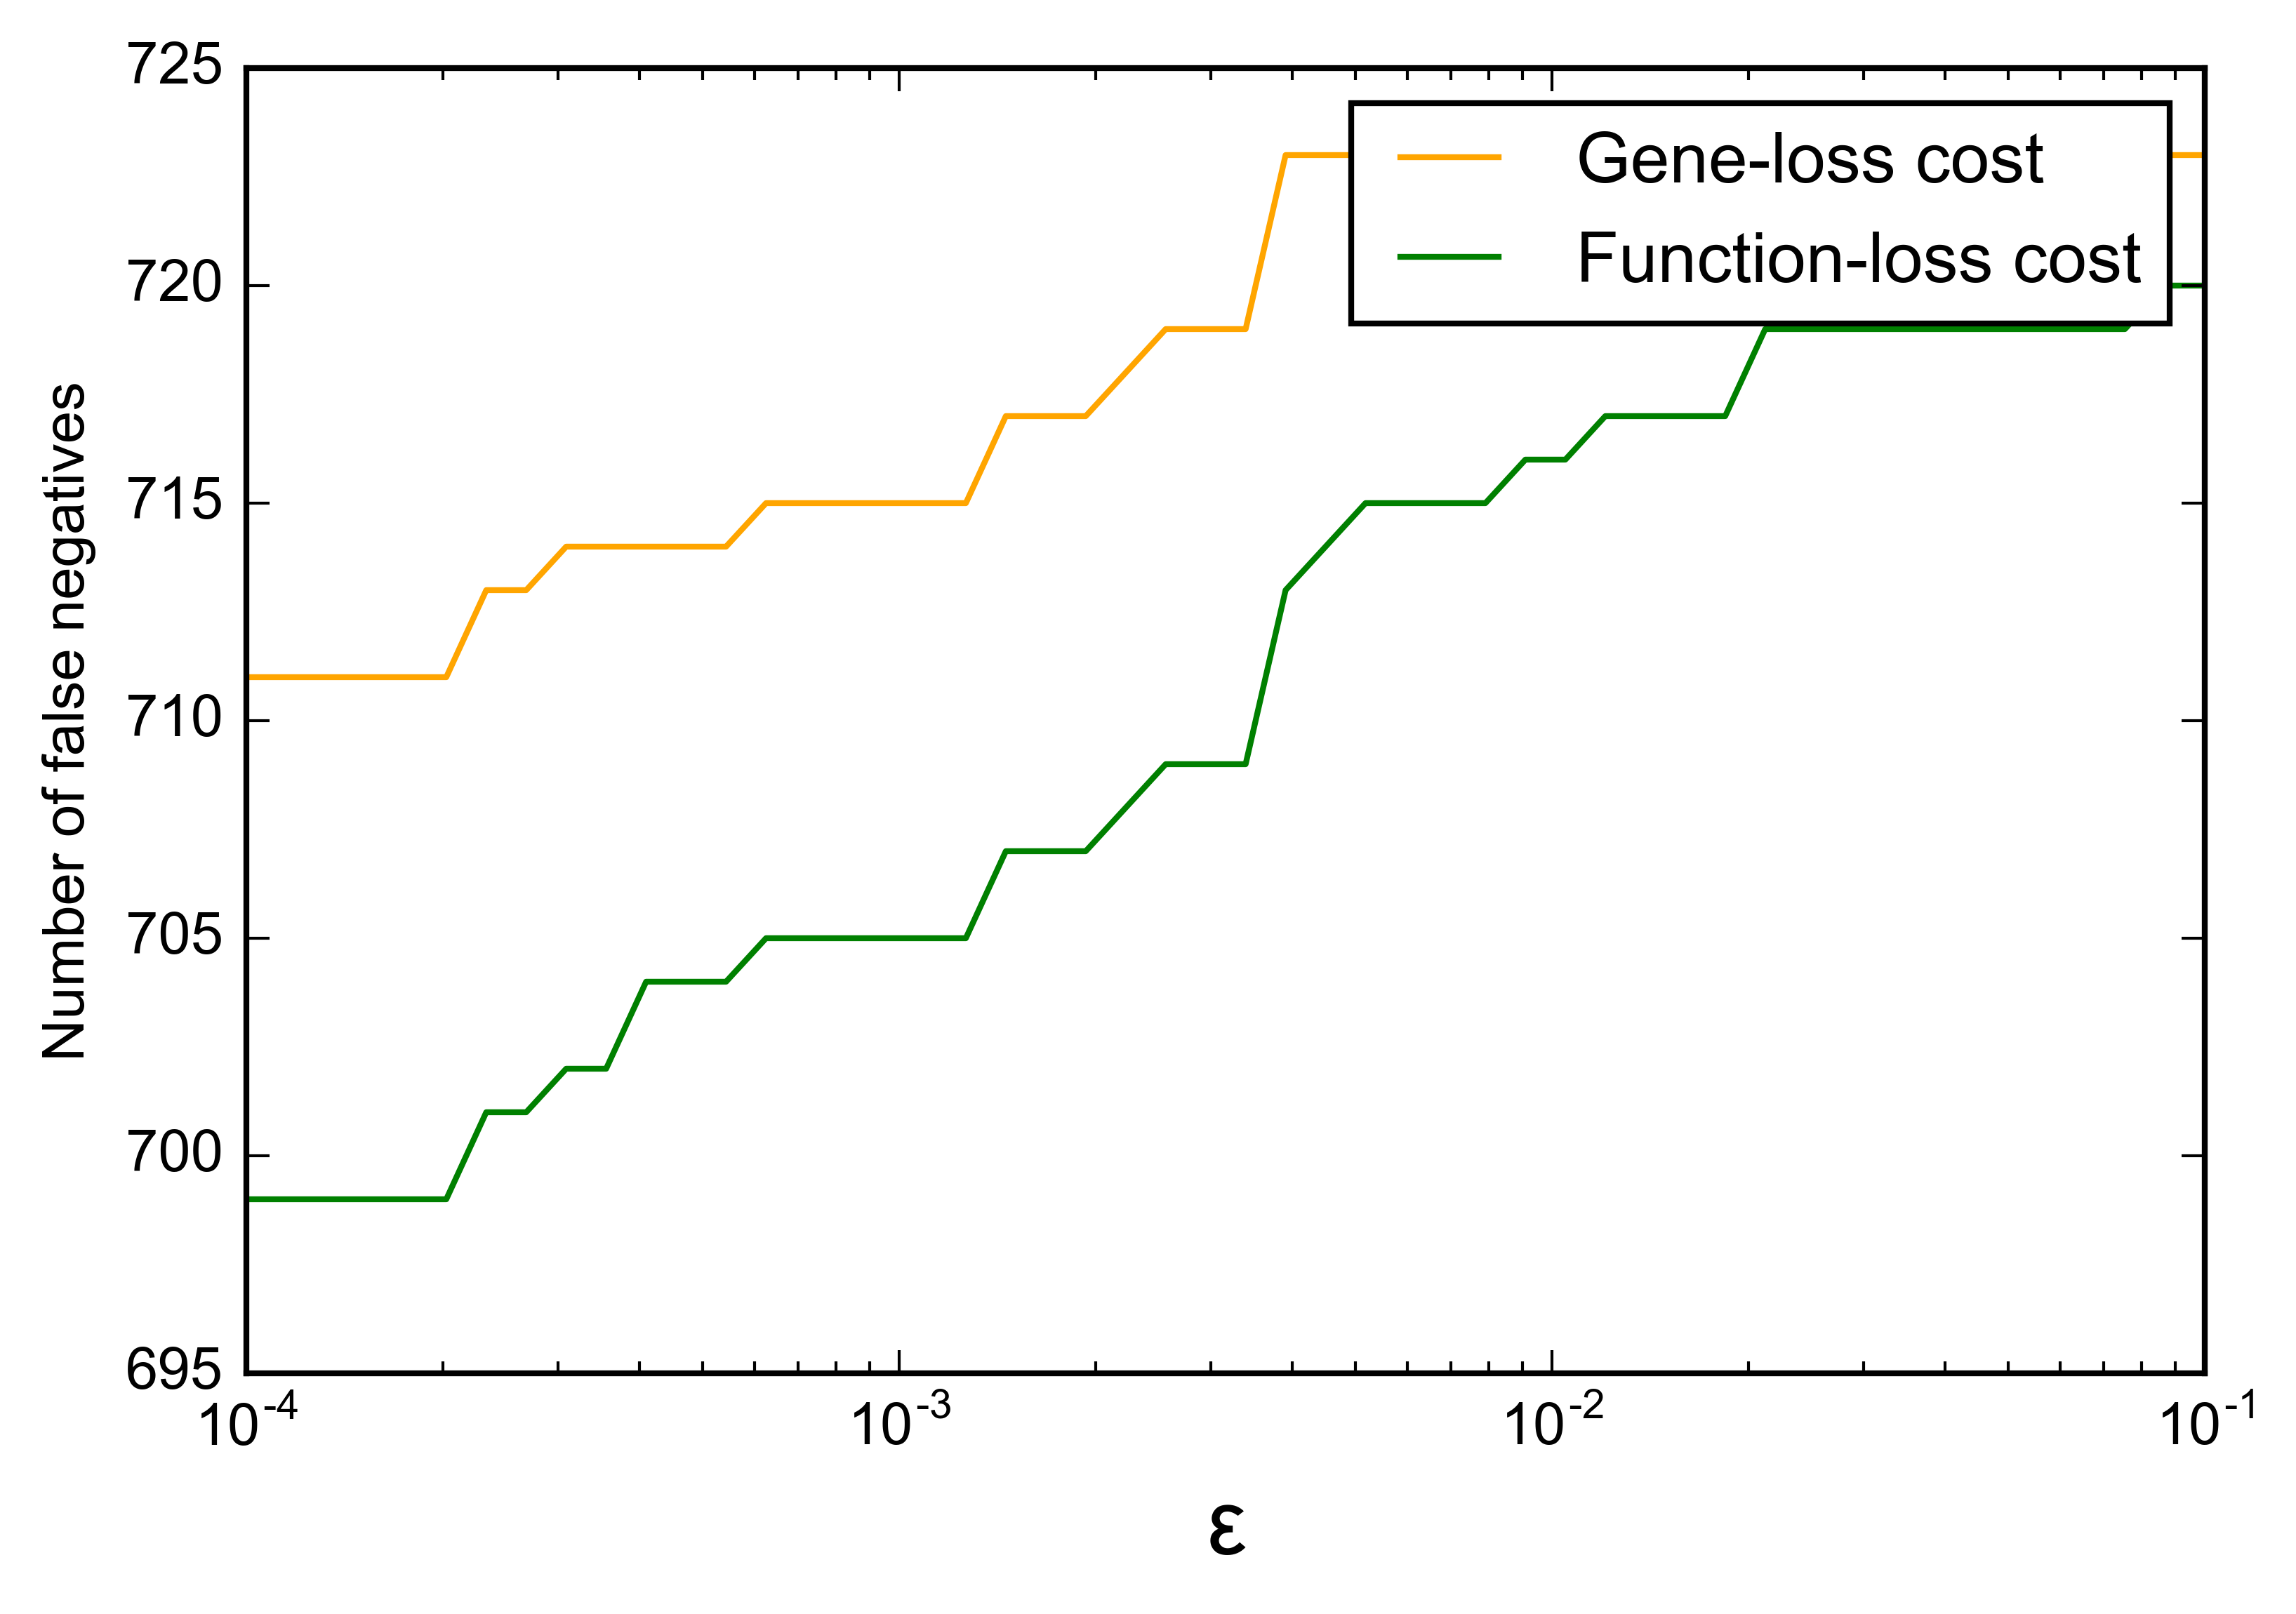

In [22]:
epsilonVals = np.logspace(-4., -1.)
glcTruePos = [get_counts(results, i)[0]['negative']['negative'] for i in epsilonVals]
flcTruePos = [get_counts(results, i)[1]['negative']['negative'] for i in epsilonVals]
glcFalsePos = [get_counts(results, i)[0]['non-interacting']['negative'] + 
               get_counts(results, i)[0]['positive']['negative']for i in epsilonVals]
flcFalsePos = [get_counts(results, i)[1]['non-interacting']['negative'] + 
               get_counts(results, i)[1]['positive']['negative']for i in epsilonVals]
glcFalseNeg = [get_counts(results, i)[0]['negative']['positive'] + 
               get_counts(results, i)[0]['negative']['non-interacting']for i in epsilonVals]
flcFalseNeg = [get_counts(results, i)[1]['negative']['positive'] + 
               get_counts(results, i)[1]['negative']['non-interacting']for i in epsilonVals]
plt.plot(epsilonVals, glcTruePos, label='Gene-loss cost', color='orange')
plt.plot(epsilonVals, flcTruePos, label='Function-loss cost', color='green')
plt.ylabel('Number of true positives')
plt.xlabel(r'$\epsilon$', fontsize=16)
plt.xscale('log')
plt.legend()
plt.show()
plt.plot(epsilonVals, glcFalsePos, label='Gene-loss cost', color='orange')
plt.plot(epsilonVals, flcFalsePos, label='Function-loss cost', color='green')
plt.ylabel('Number of false positives')
plt.xlabel(r'$\epsilon$', fontsize=16)
plt.xscale('log')
plt.legend()
plt.show()
plt.plot(epsilonVals, glcFalseNeg, label='Gene-loss cost', color='orange')
plt.plot(epsilonVals, flcFalseNeg, label='Function-loss cost', color='green')
plt.ylabel('Number of false negatives')
plt.xlabel(r'$\epsilon$', fontsize=16)
plt.xscale('log')
plt.legend()
plt.show()

In [23]:
print sum(results['epsilon_glc'].abs() < 0.00001), 'out of', results.shape[0],
print 'Gene-loss cost double knockouts with |epsilon| < 1e-5'
print sum(results['epsilon_flc'].abs() < 0.00001), 'out of', results.shape[0],
print 'Function-loss cost double knockouts with |epsilon| < 1e-5'

22576 out of 23211 Gene-loss cost double knockouts with |epsilon| < 1e-5
21606 out of 23211 Function-loss cost double knockouts with |epsilon| < 1e-5


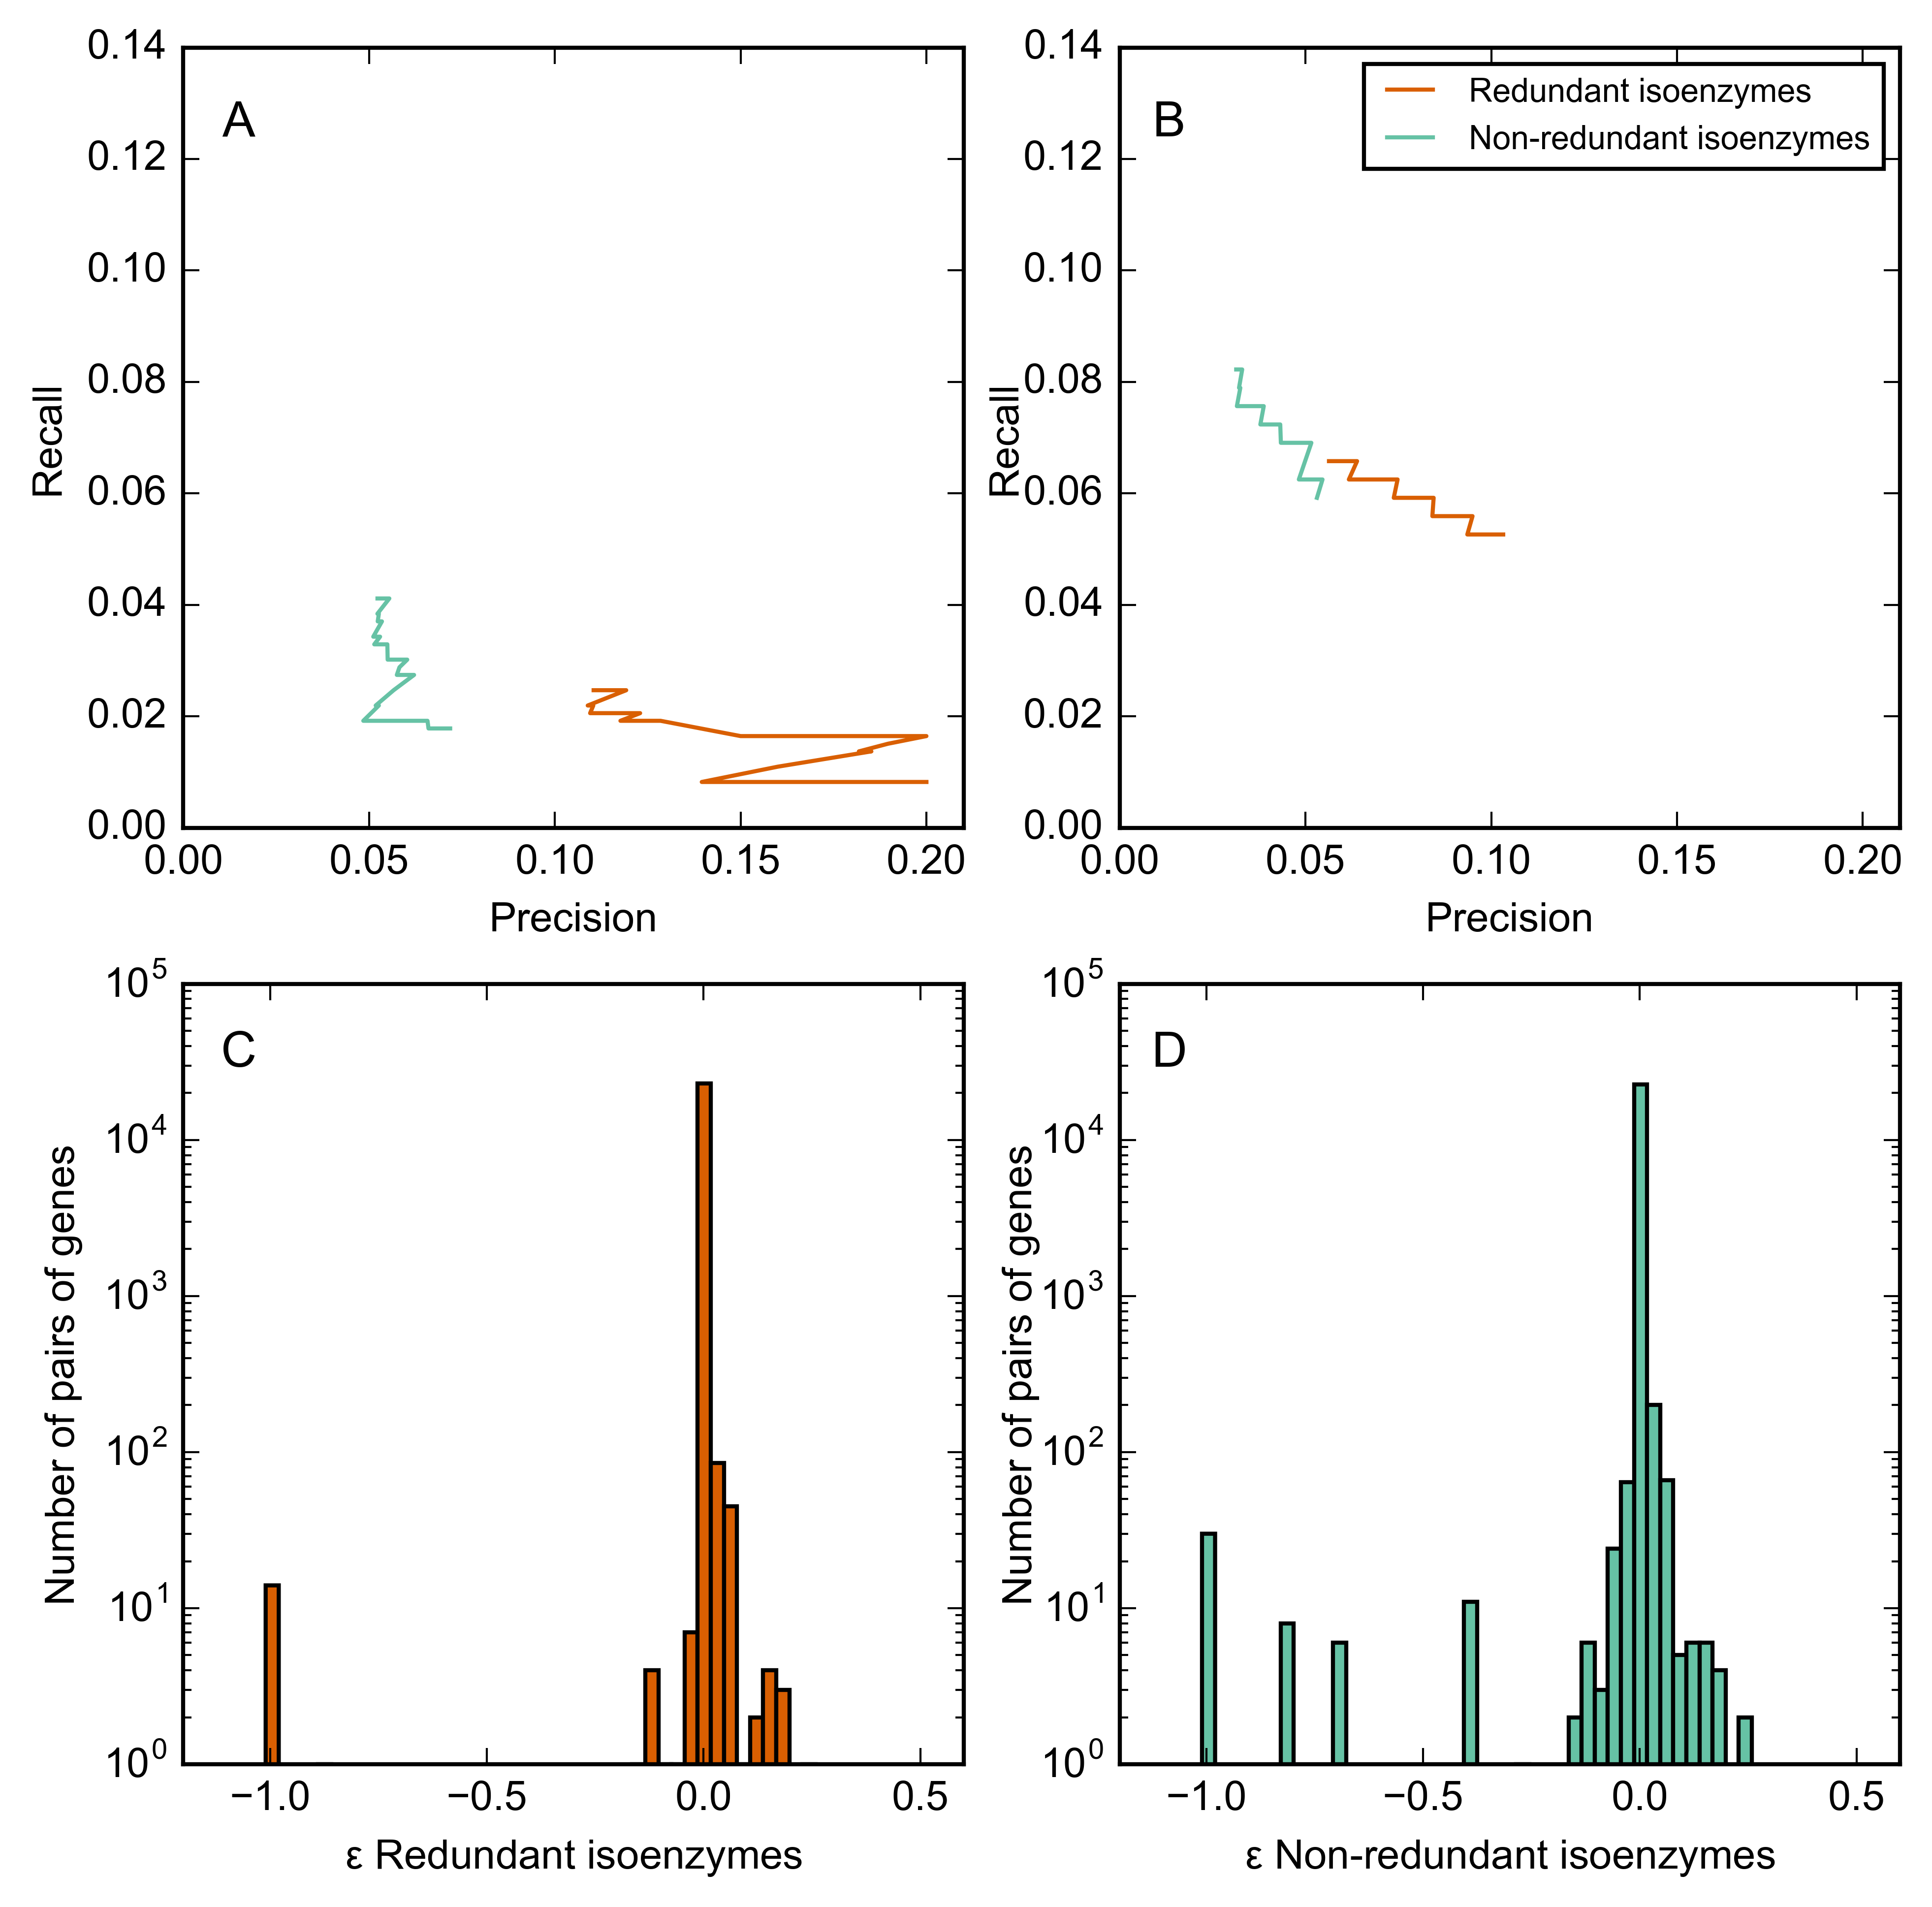

In [24]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(7.5)
fig.set_figwidth(7.5)
precision_recall_curve(ax[0, 0], prGLCNeg, prFLCNeg, drawLegend=False)
precision_recall_curve(ax[0, 1], prGLCPos, prFLCPos)
ax[0, 1].set_ylabel('Recall', labelpad=-0.05)
nBins = 50
rng = (-1.01, 0.5)
ax[1, 0].hist(results['epsilon_glc'].values, range=rng, bins=nBins, color='#d95f02')
ax[1, 0].set_yscale('log')
ax[1, 0].set_xlabel('$\epsilon$ Redundant isoenzymes')
ax[1, 0].set_ylabel('Number of pairs of genes')
ax[1, 1].hist(results['epsilon_flc'].values, range=rng, bins=nBins, color='#66c2a5')
ax[1, 1].set_yscale('log')
ax[1, 1].set_xlabel('$\epsilon$ Non-redundant isoenzymes')
ax[1, 1].set_ylabel('Number of pairs of genes', labelpad=-0.05)
letterFS = 12
fig.text(0.15,0.86, 'A', fontsize=letterFS, horizontalalignment='center')
fig.text(0.57,0.86, 'B', fontsize=letterFS, horizontalalignment='center')
fig.text(0.15,0.44, 'C', fontsize=letterFS, horizontalalignment='center')
fig.text(0.57,0.44, 'D', fontsize=letterFS, horizontalalignment='center')
plt.savefig(os.path.join(figDir, 'latest_revision_figureS5.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figureS5.eps'), bbox_inches='tight')
plt.savefig(os.path.join(figDir, 'latest_revision_figureS5.svg'), bbox_inches='tight')
plt.show()